In [19]:
# Import the required library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity,calculate_kmo

In [5]:
""" Create an method to read the csv file with the seperation process
    fp : File path
"""
def read_dataFile(fp):
    # Read the file 
    file = open(fp,"r", encoding ="utf-8" )
    # Get read each of lines in the csv file
    lines = file.readlines()
    # Get the first line to seperate each name in columns 
    first_line = lines.pop(0)
    # Clean the empty space by strip(); And replace the "" on column names and seperate names by ";"
    col_names = first_line.strip().replace('"', '').split(';')
    # Deal with the left lines
    data = []
    # Iterate each line to process the data which is only seperate by the ";"
    for line in lines:
        tmp_l = line.strip().split(';') # tmp_l is temperal line
        data.append(tmp_l)
    # Form a data frame for future processing
    df = pd.DataFrame(data, columns=col_names)
    # Check the dataframe (first five lines)
    print(df.head())
    return df
# 

In [7]:
# method to deal with current data frame
original_data = read_dataFile("winequality-red-4.csv")
# We copy the original data into a variable for the following process
wine_data = original_data.copy()

  fixed acidity volatile acidity citric acid residual sugar chlorides  \
0           7.4              0.7           0            1.9     0.076   
1           7.8             0.88           0            2.6     0.098   
2           7.8             0.76        0.04            2.3     0.092   
3          11.2             0.28        0.56            1.9     0.075   
4           7.4              0.7           0            1.9     0.076   

  free sulfur dioxide total sulfur dioxide density    pH sulphates alcohol  \
0                  11                   34  0.9978  3.51      0.56     9.4   
1                  25                   67  0.9968   3.2      0.68     9.8   
2                  15                   54   0.997  3.26      0.65     9.8   
3                  17                   60   0.998  3.16      0.58     9.8   
4                  11                   34  0.9978  3.51      0.56     9.4   

  quality  
0       5  
1       5  
2       5  
3       6  
4       5  


In [9]:
"""
Check whether this data frame missing some values in some columns
"""
def check_missing_value(df):
    # Display the info of this dataframe
    # In this displacement, there is no missing value because of the 1599 entries, 
    # However, the Dtype displacement shows objects that means there may exist some error for data type
    df.info()
    # We plan to convert the all data into a numeric type
    for r in df.columns:
        df[r] = pd.to_numeric(df[r], errors='coerce')
    # After the transformation, the result we get
    print("\nAfter modification: ")
    print(df.info())
    print('\nNumber of Missing Values: ')
    print(df.isnull().sum())
    print(df.head())

    return df



In [11]:
# Apply the missing value method
wine_data_no_missingvalue = check_missing_value(wine_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   fixed acidity         1599 non-null   object
 1   volatile acidity      1599 non-null   object
 2   citric acid           1599 non-null   object
 3   residual sugar        1599 non-null   object
 4   chlorides             1599 non-null   object
 5   free sulfur dioxide   1599 non-null   object
 6   total sulfur dioxide  1599 non-null   object
 7   density               1599 non-null   object
 8   pH                    1599 non-null   object
 9   sulphates             1599 non-null   object
 10  alcohol               1599 non-null   object
 11  quality               1599 non-null   object
dtypes: object(12)
memory usage: 150.0+ KB

After modification: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column          

In [13]:
"Third Step: This method will focus on outlier data, we will plot the picture first, then we will replace the outlier values with the IQR data"
def outlier_procedure(df):
    # We have to plot all attributes first to observe distribution
    digital_part = df.columns[:-1]
    # Set the figures
    plt.figure(figsize=(15, 20))

    # Plot every feature with histogram 
    for i, variable in enumerate(digital_part):
        # Create the subplot
        plt.subplot(4, 3, i + 1)
        # Create the histogram for each feature
        sns.histplot(df[variable].astype(float), bins=30, color='skyblue', edgecolor='black', linewidth=2, label='Data', alpha=0.5, kde= True)
        # Add the title to each 
        plt.title(f'Distribution of {variable}')
        # Add the x-axis label
        plt.xlabel(variable)
        # Add the y axis label
        plt.ylabel('Frequency')
        plt.legend()
    
    # Get the wine quality list 
    wine_list = sorted(df["quality"].unique())
    # Display the boxplot to observe the outlier first, then we will decide which method to delete the outlier in the dataset.
    for feature in digital_part:
        # Set the figure size 
        plt.figure(figsize=(20, 15))
        # Plot the boxplot depends on the wine quality 
        sns.boxplot(x="quality", y=feature, data=df, palette="Set2")
        # Add related labels
        plt.title(f"Boxplot of {feature} by Wine Quality", fontsize=10, fontweight='bold')
        plt.xlabel("Wine Quality", fontsize=12)
        plt.ylabel(feature, fontsize=12)
        plt.show()
    
    
 
        
    # We apply the IQR method to deal with outlier. IQR is a statistical method to detect and deal with outliers in various distributions, especially for right skewness or left skewness data set.
    """
    The lower bound = Q1 - 1.5 * IQR
    The upper bound = Q3 + 1.5 * IQR
    If the data exceed the lower bound or the upper bound, this data is a outlier. 
    """

    df_copy = df.copy() # Copy a dataframe for current work. Keep the original data for other goals.     
    #print("Unique values in 'quality':", df_copy["quality"].unique())
    # Get all volume names and convert to list
    volume_names = df_copy.columns.tolist()
    # We iterate each feature and replace the outlier with reasonable 
    for variable in volume_names:
        for q in wine_list:
            # Get the target dataset
            q_data_set = df_copy[df_copy["quality"] == q]
            
            # Calculate the Q1 and Q3 
            Q1 = q_data_set[variable].quantile(0.75)
            Q3 = q_data_set[variable].quantile(0.25)
            # This is the formula to get the IQR
            IQR = Q3 - Q1
            # Calculate the lower bound and upper bound
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            # If the outlier exists, we replace the number between 2 bound 
            df_copy.loc[df_copy["quality"] == q, variable] = np.clip(q_data_set[variable], lower_bound, upper_bound)
            
    # This part use the updated dataframe
    digital_part2 = df_copy.columns[:-1]
    
    # This box plot will display the dataframe with no outlier.
    for feature in digital_part2:
        # Set the figure size 
        plt.figure(figsize=(20, 15))
        # Plot the boxplot depends on the wine quality 
        sns.boxplot(x="quality", y=feature, data=df_copy, palette="Set2")
        # Add related labels
        plt.title(f"Boxplot of {feature} by Wine Quality After Removing Outlier", fontsize=10, fontweight='bold')
        plt.xlabel("Wine Quality", fontsize=12)
        plt.ylabel(feature, fontsize=12)
        plt.show()
    
    df_copy.to_csv("cleaned_wine_data.csv", index=False)

    return df_copy
        


C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df, palette="Set2")


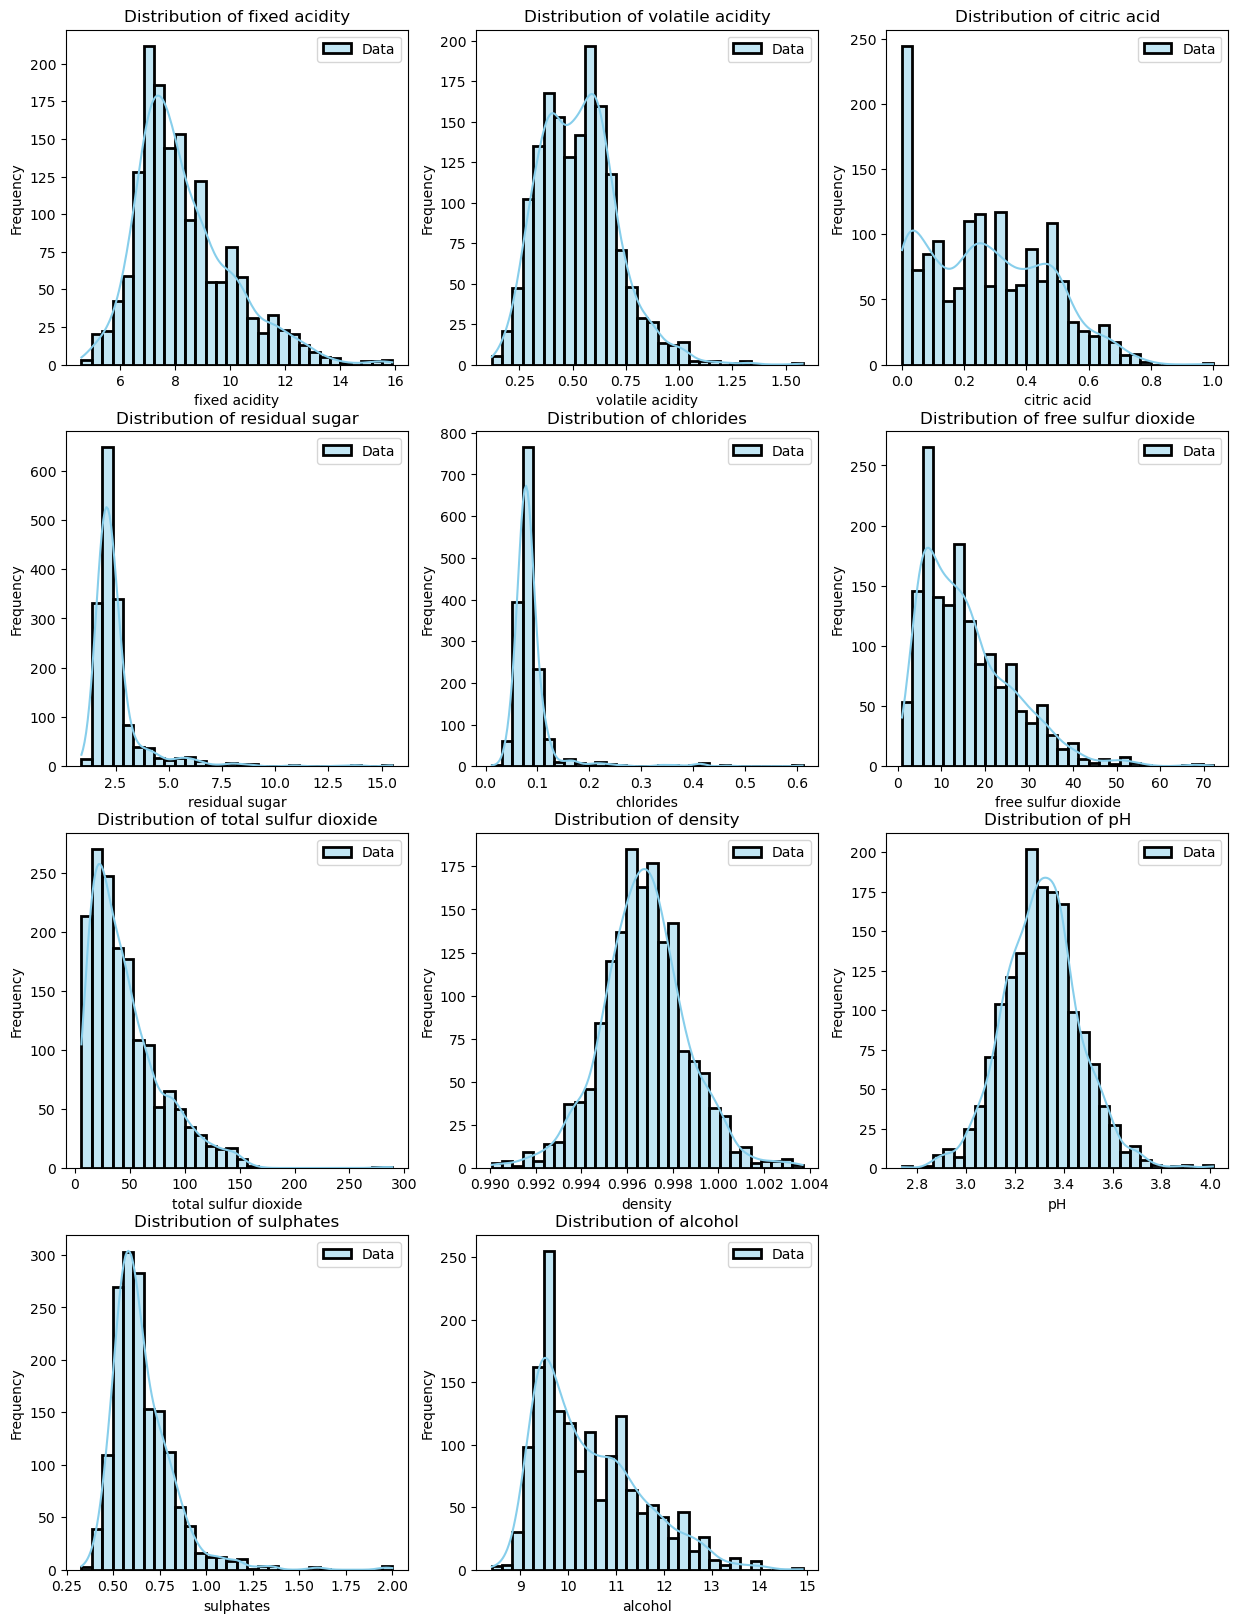

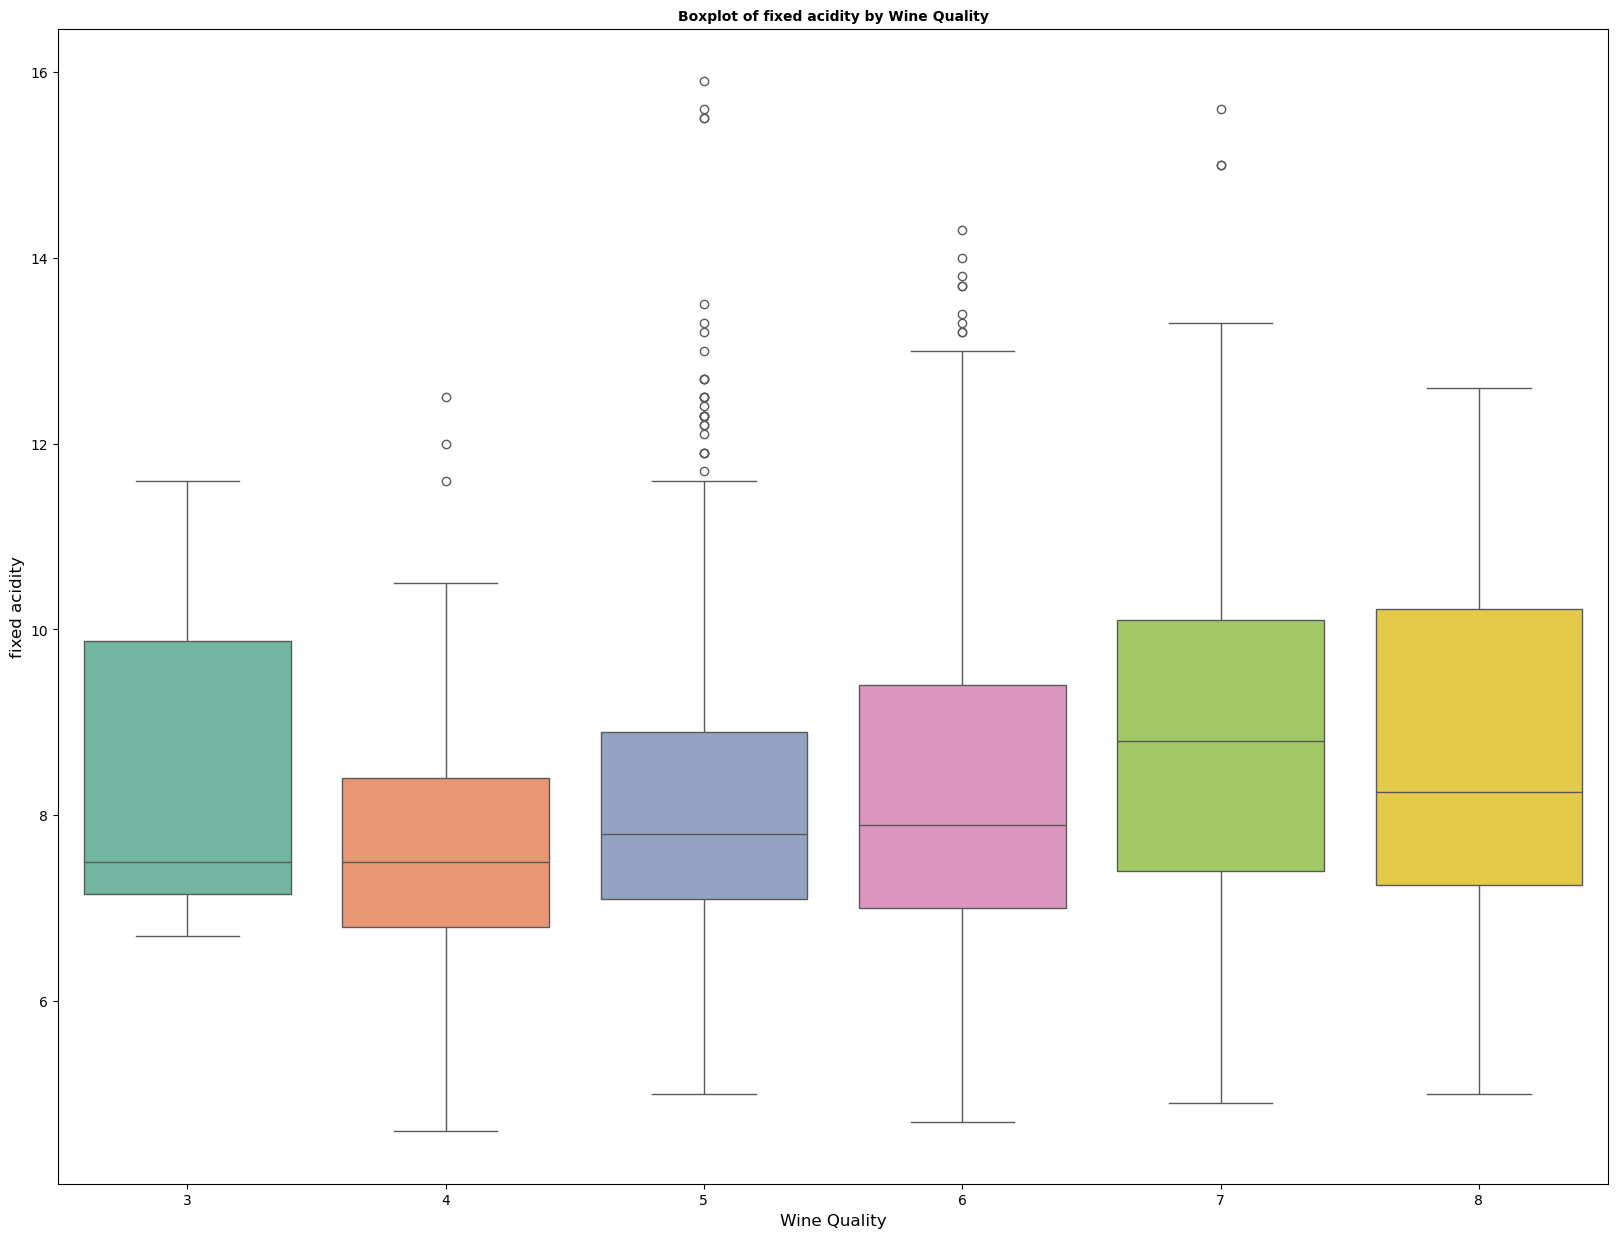

C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df, palette="Set2")


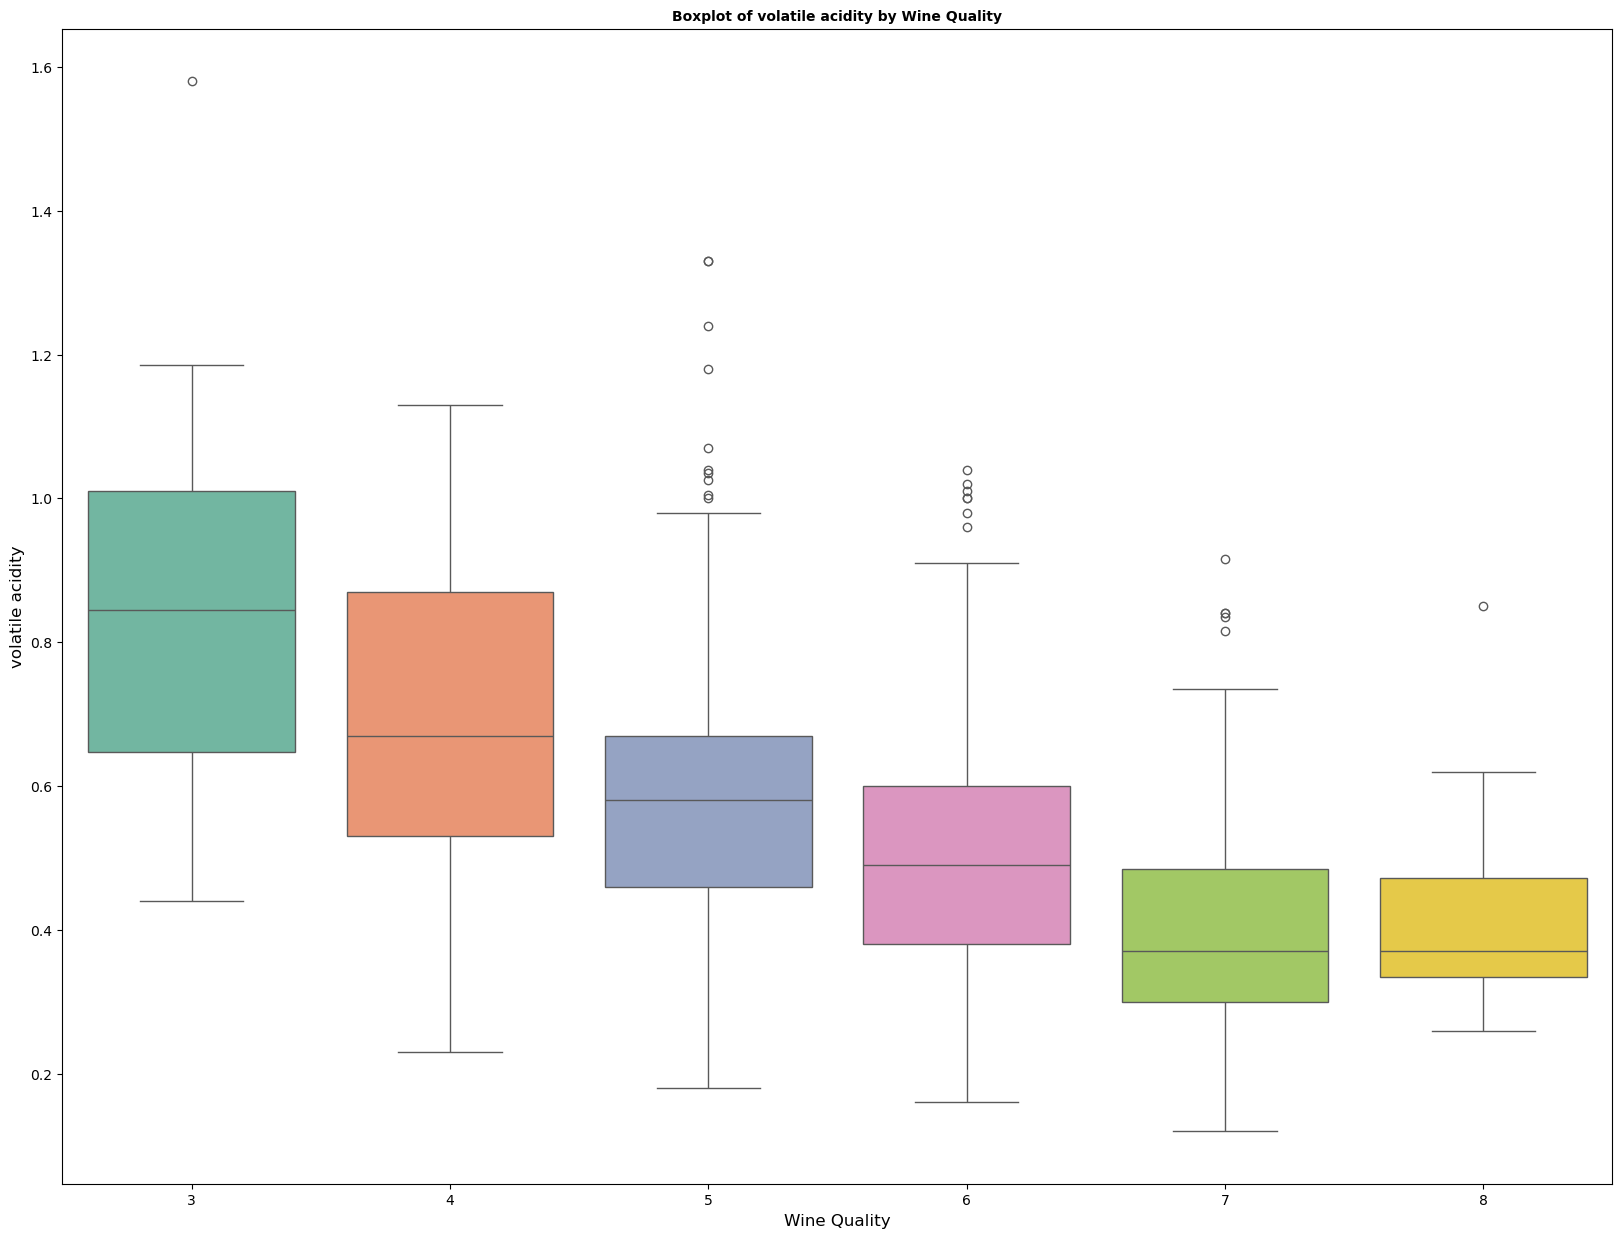

C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df, palette="Set2")


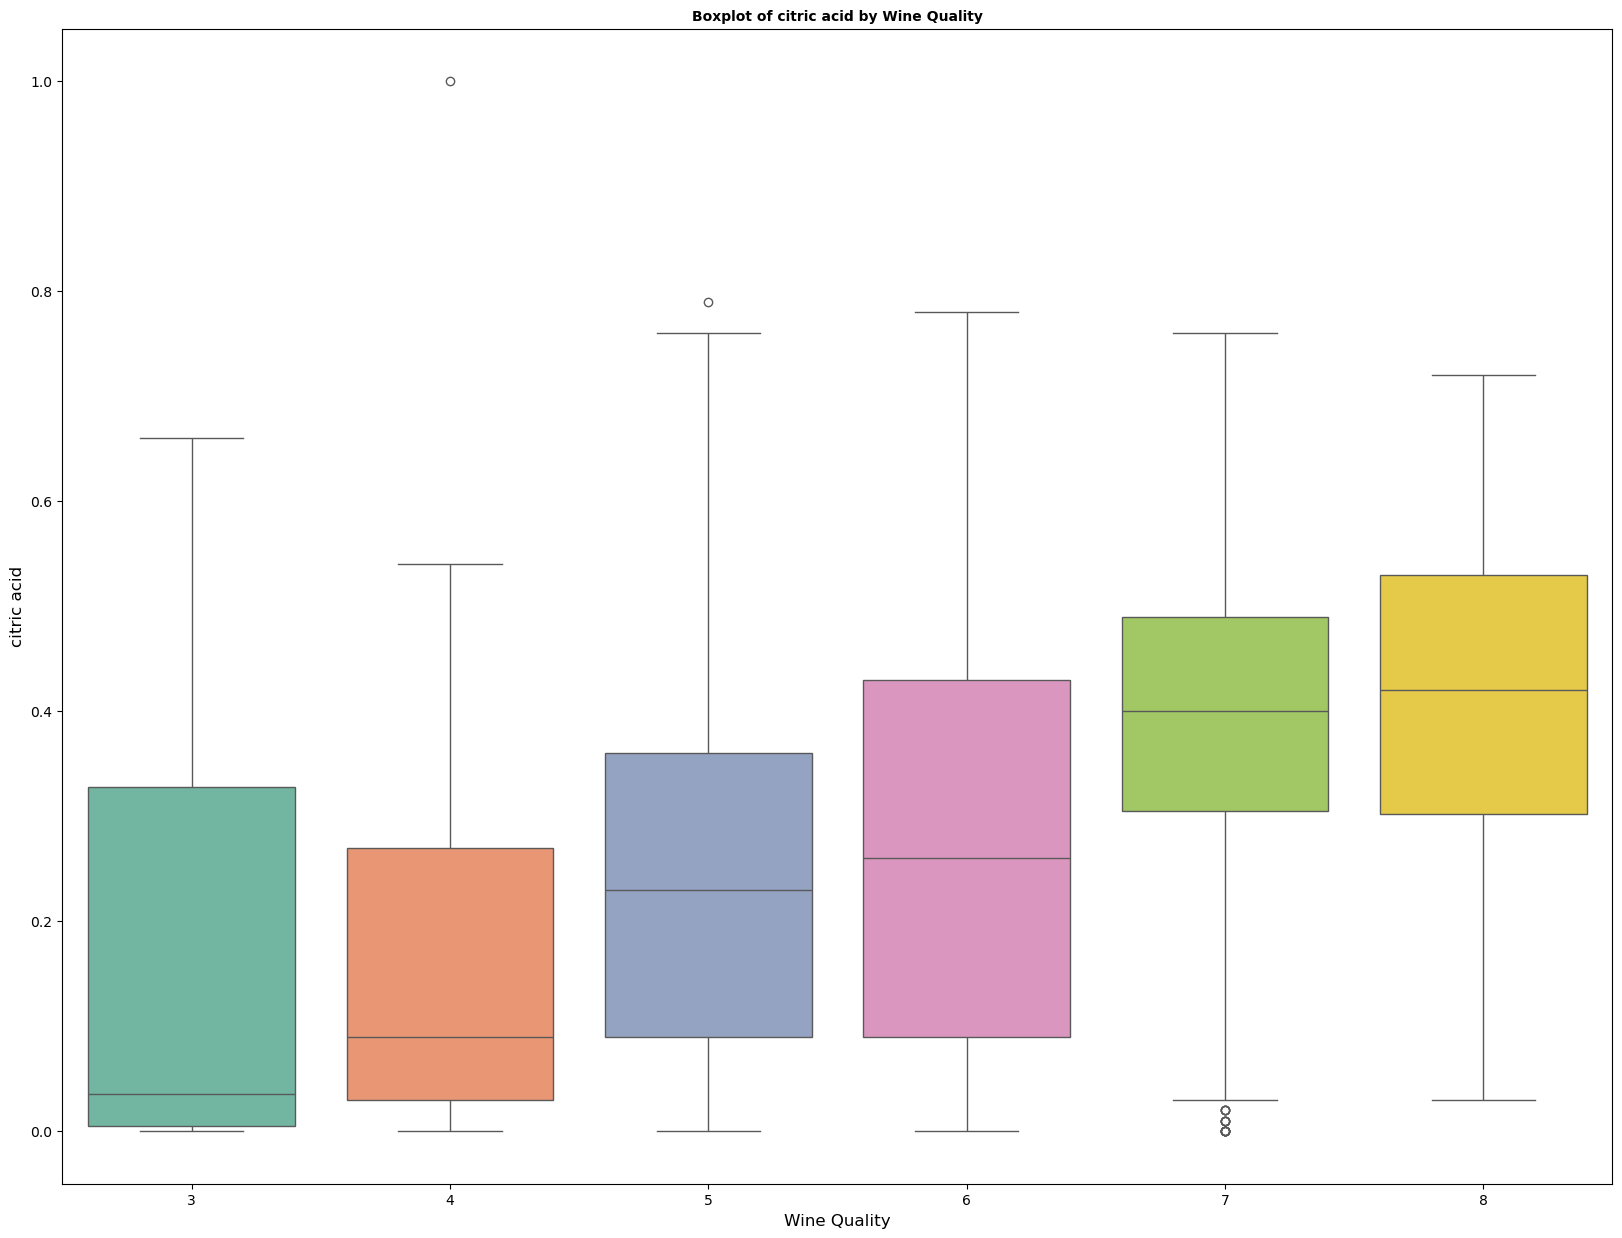

C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df, palette="Set2")


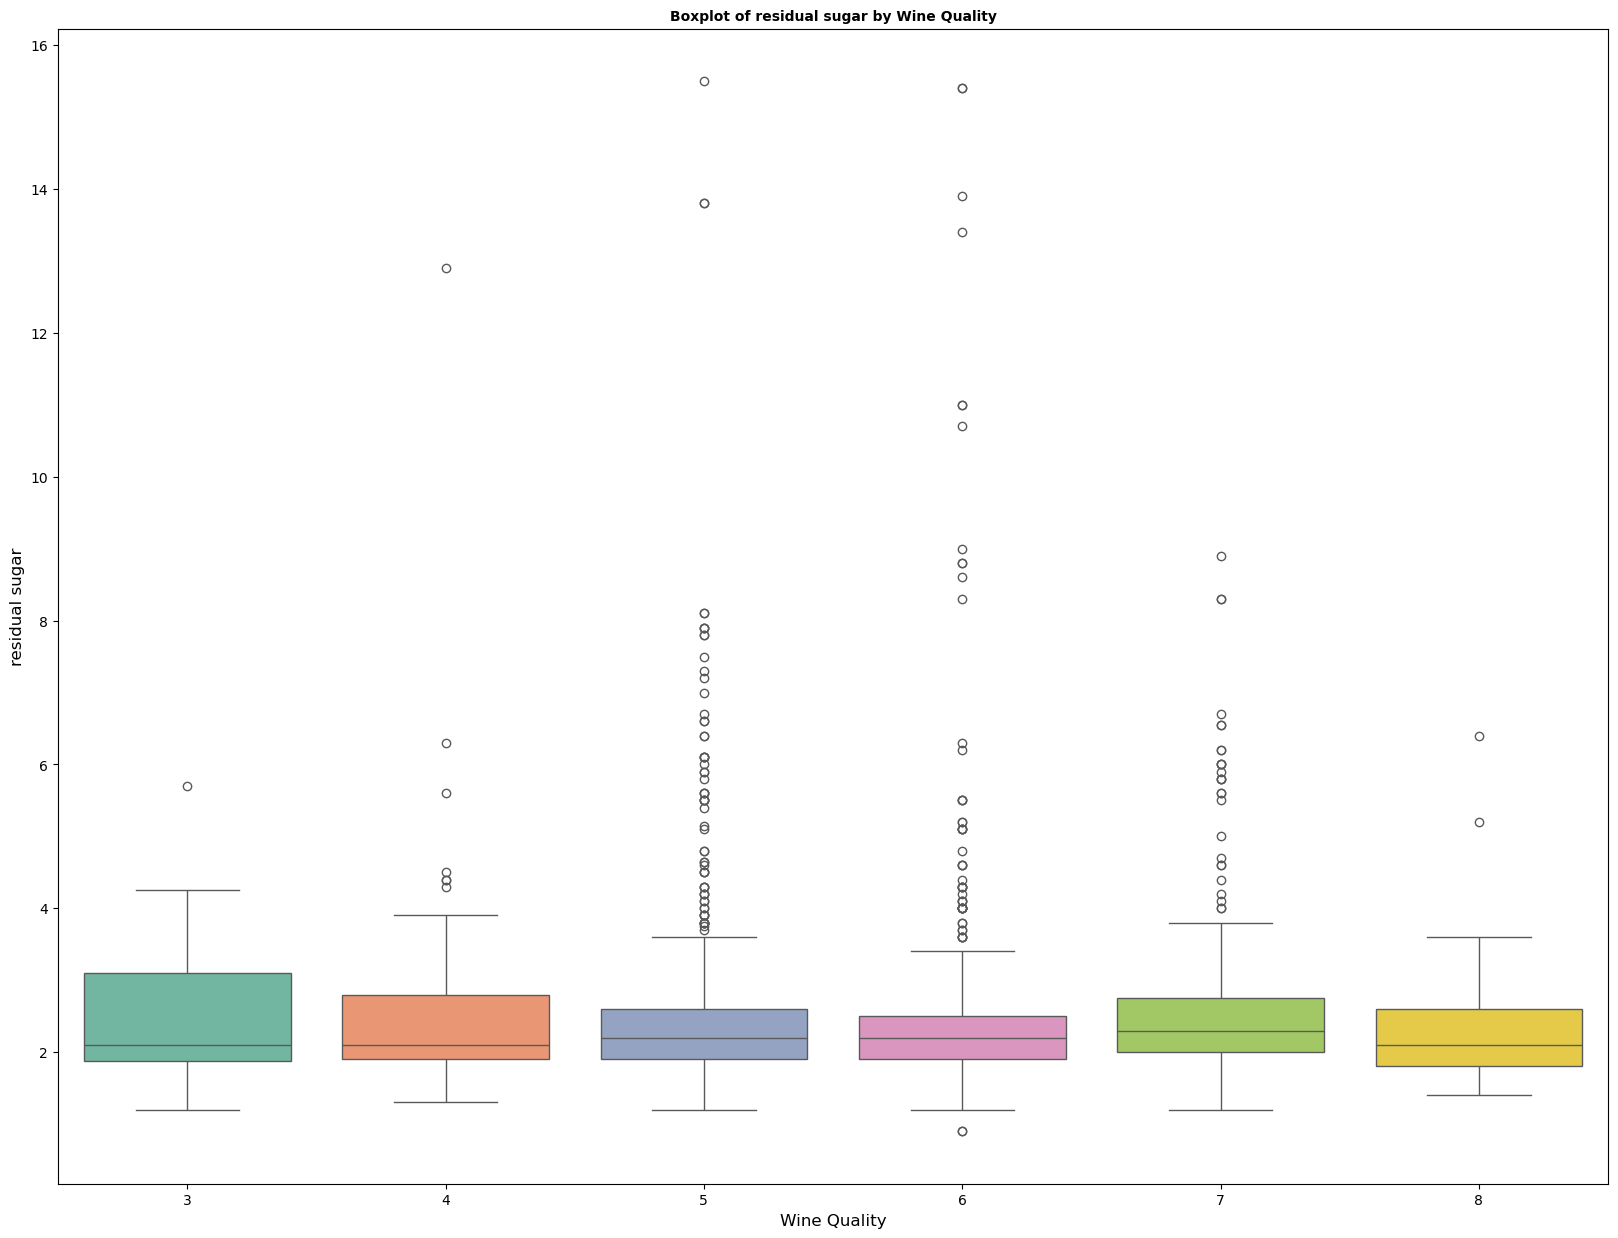

C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df, palette="Set2")


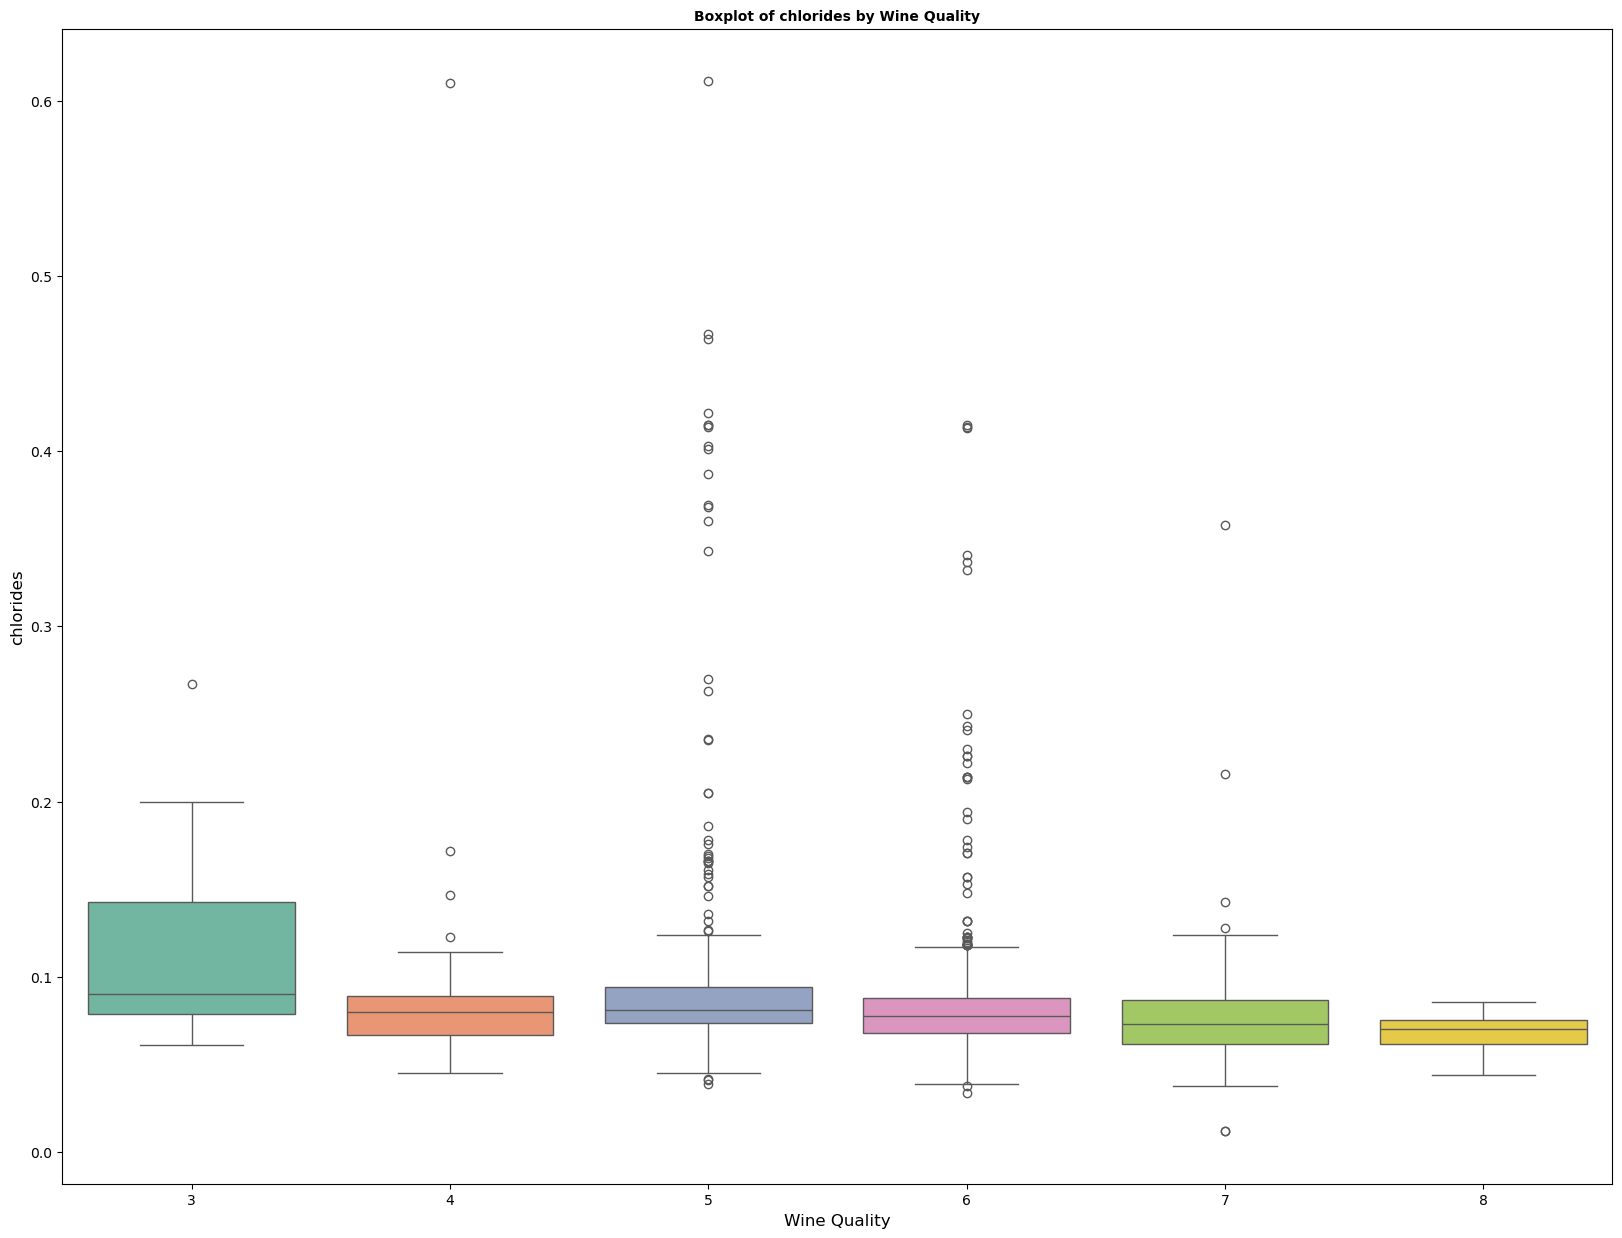

C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df, palette="Set2")


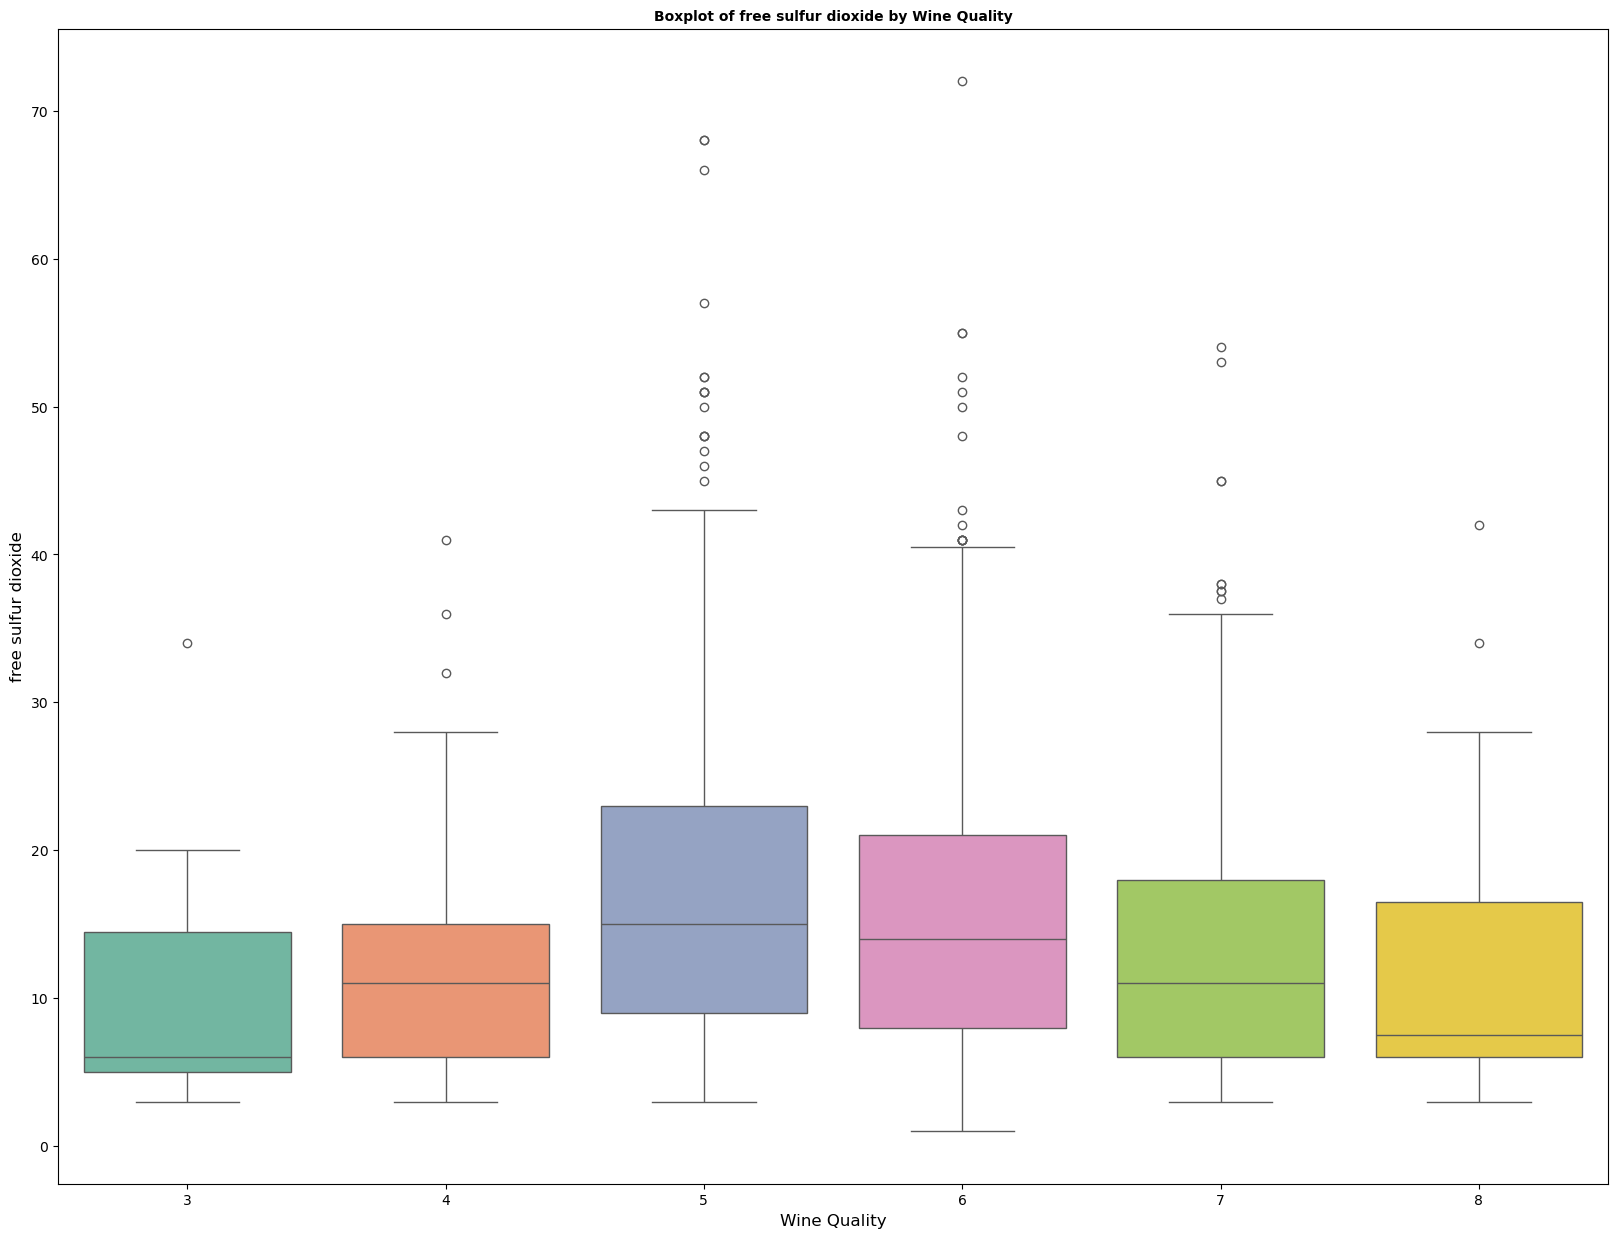

C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df, palette="Set2")


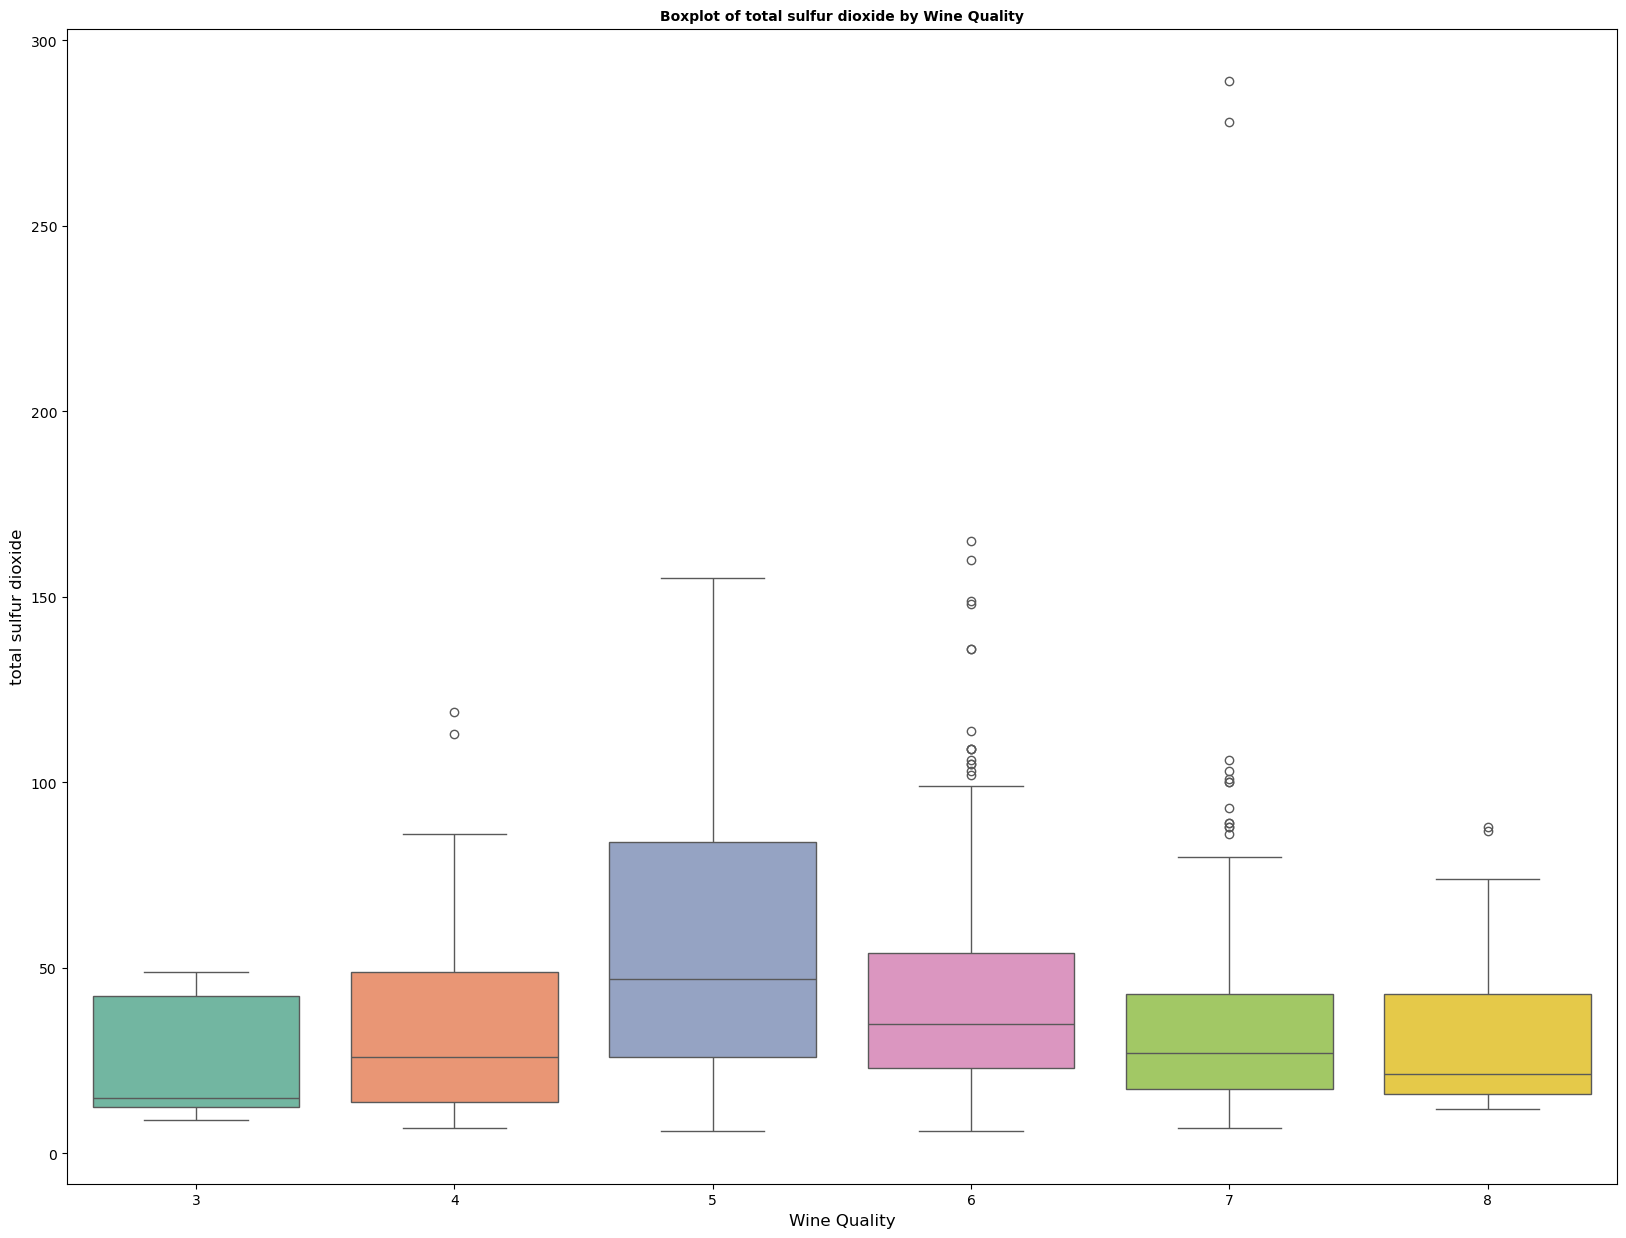

C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df, palette="Set2")


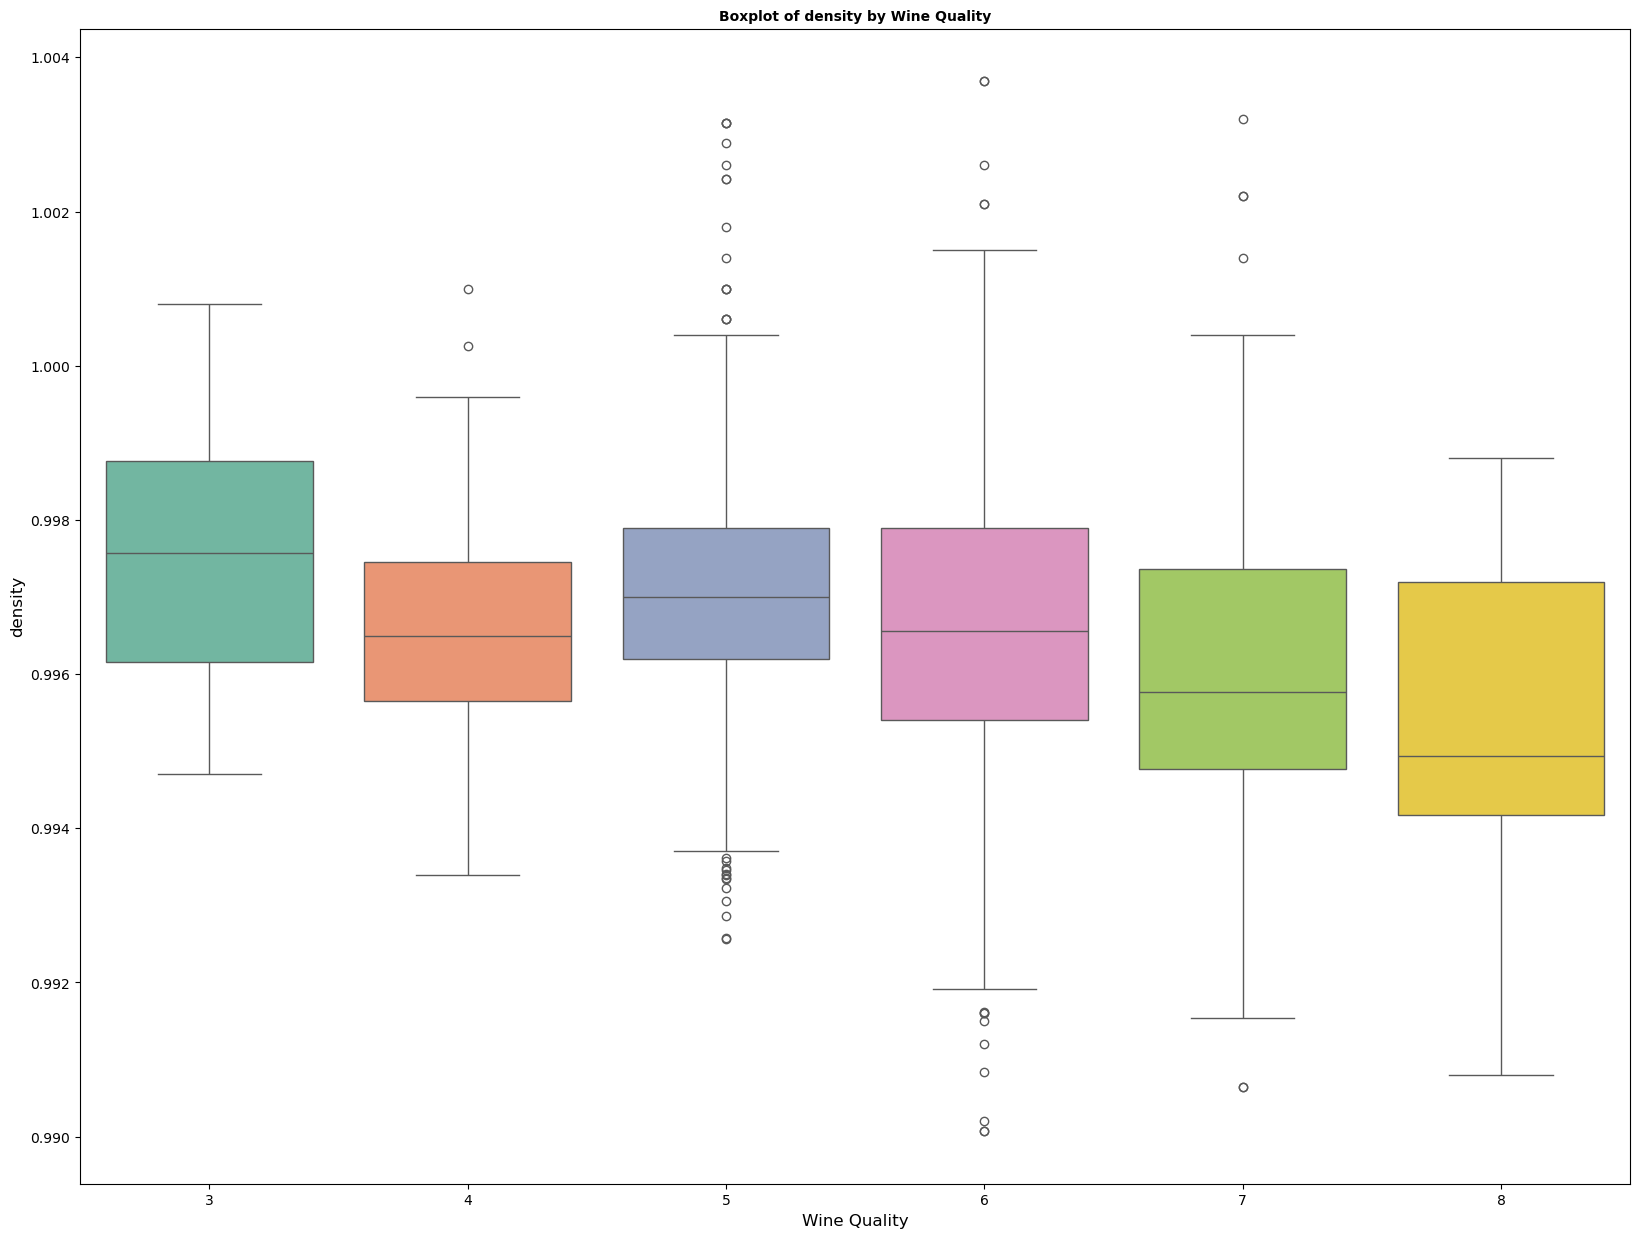

C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df, palette="Set2")


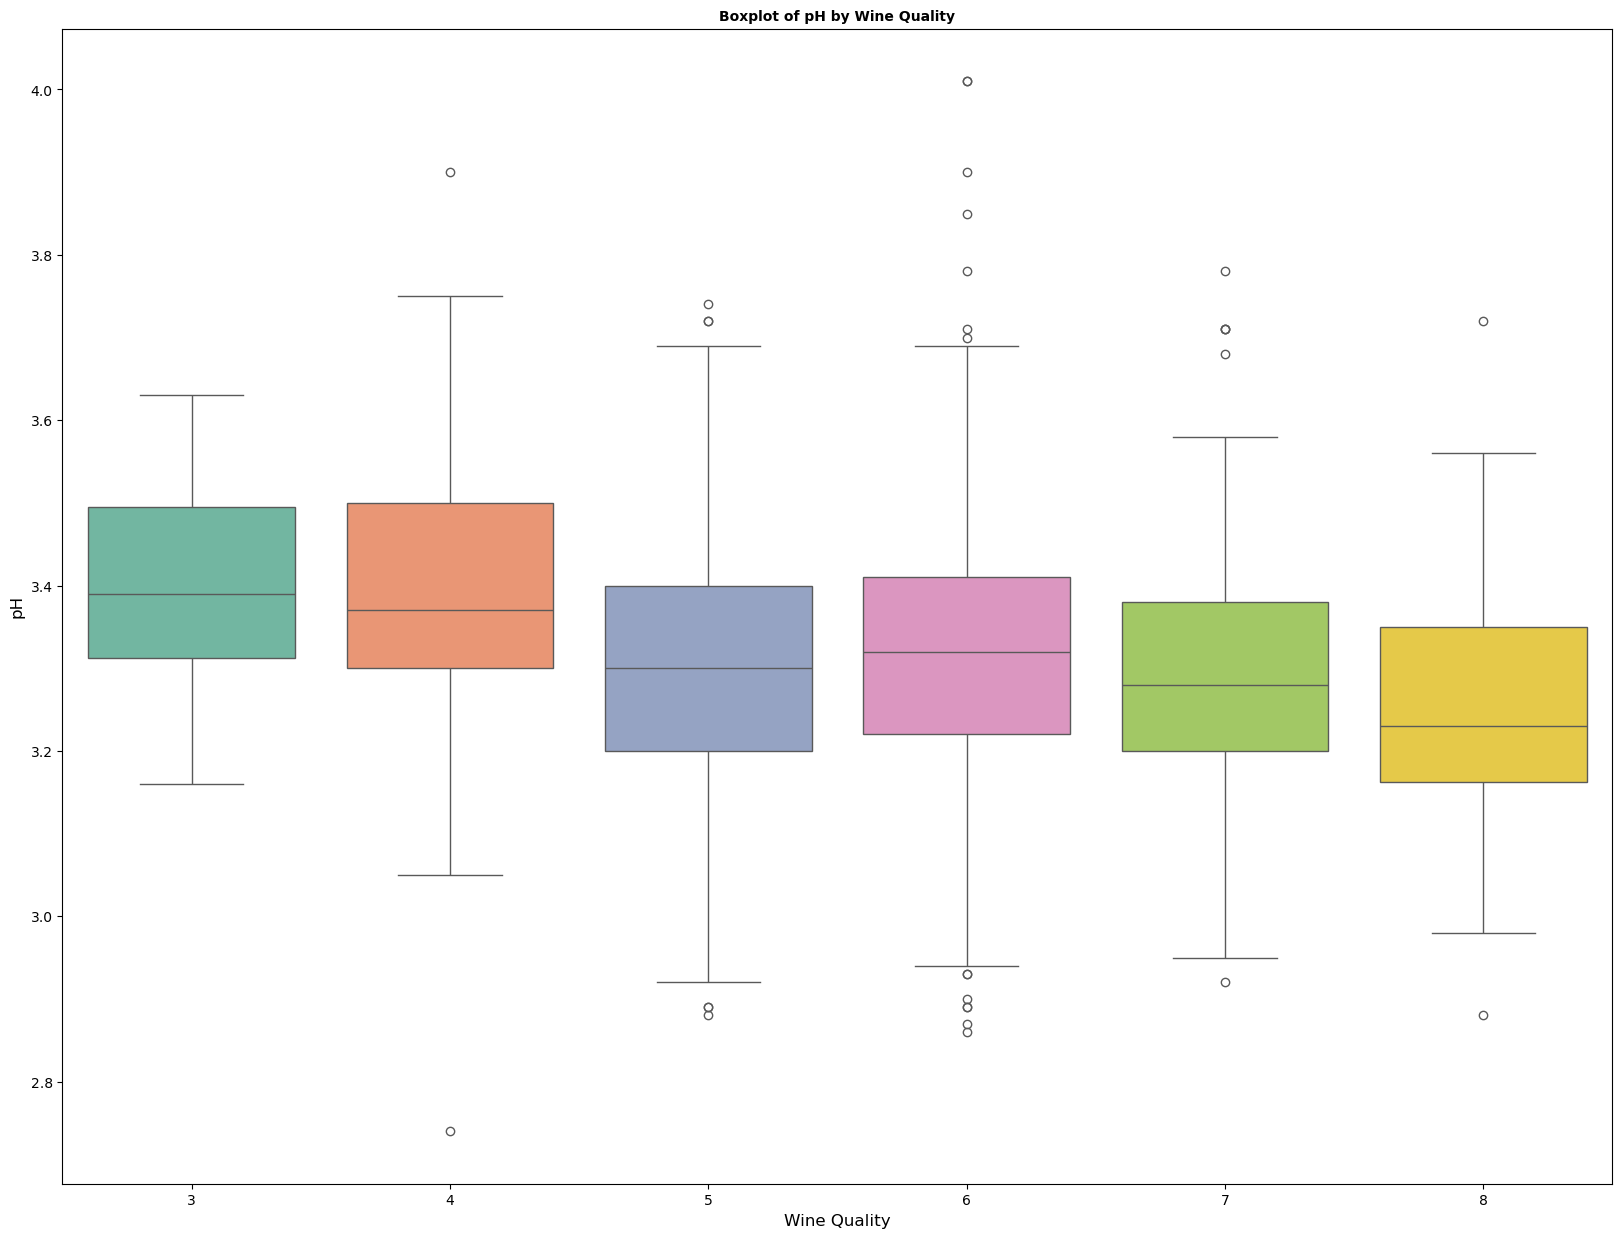

C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df, palette="Set2")


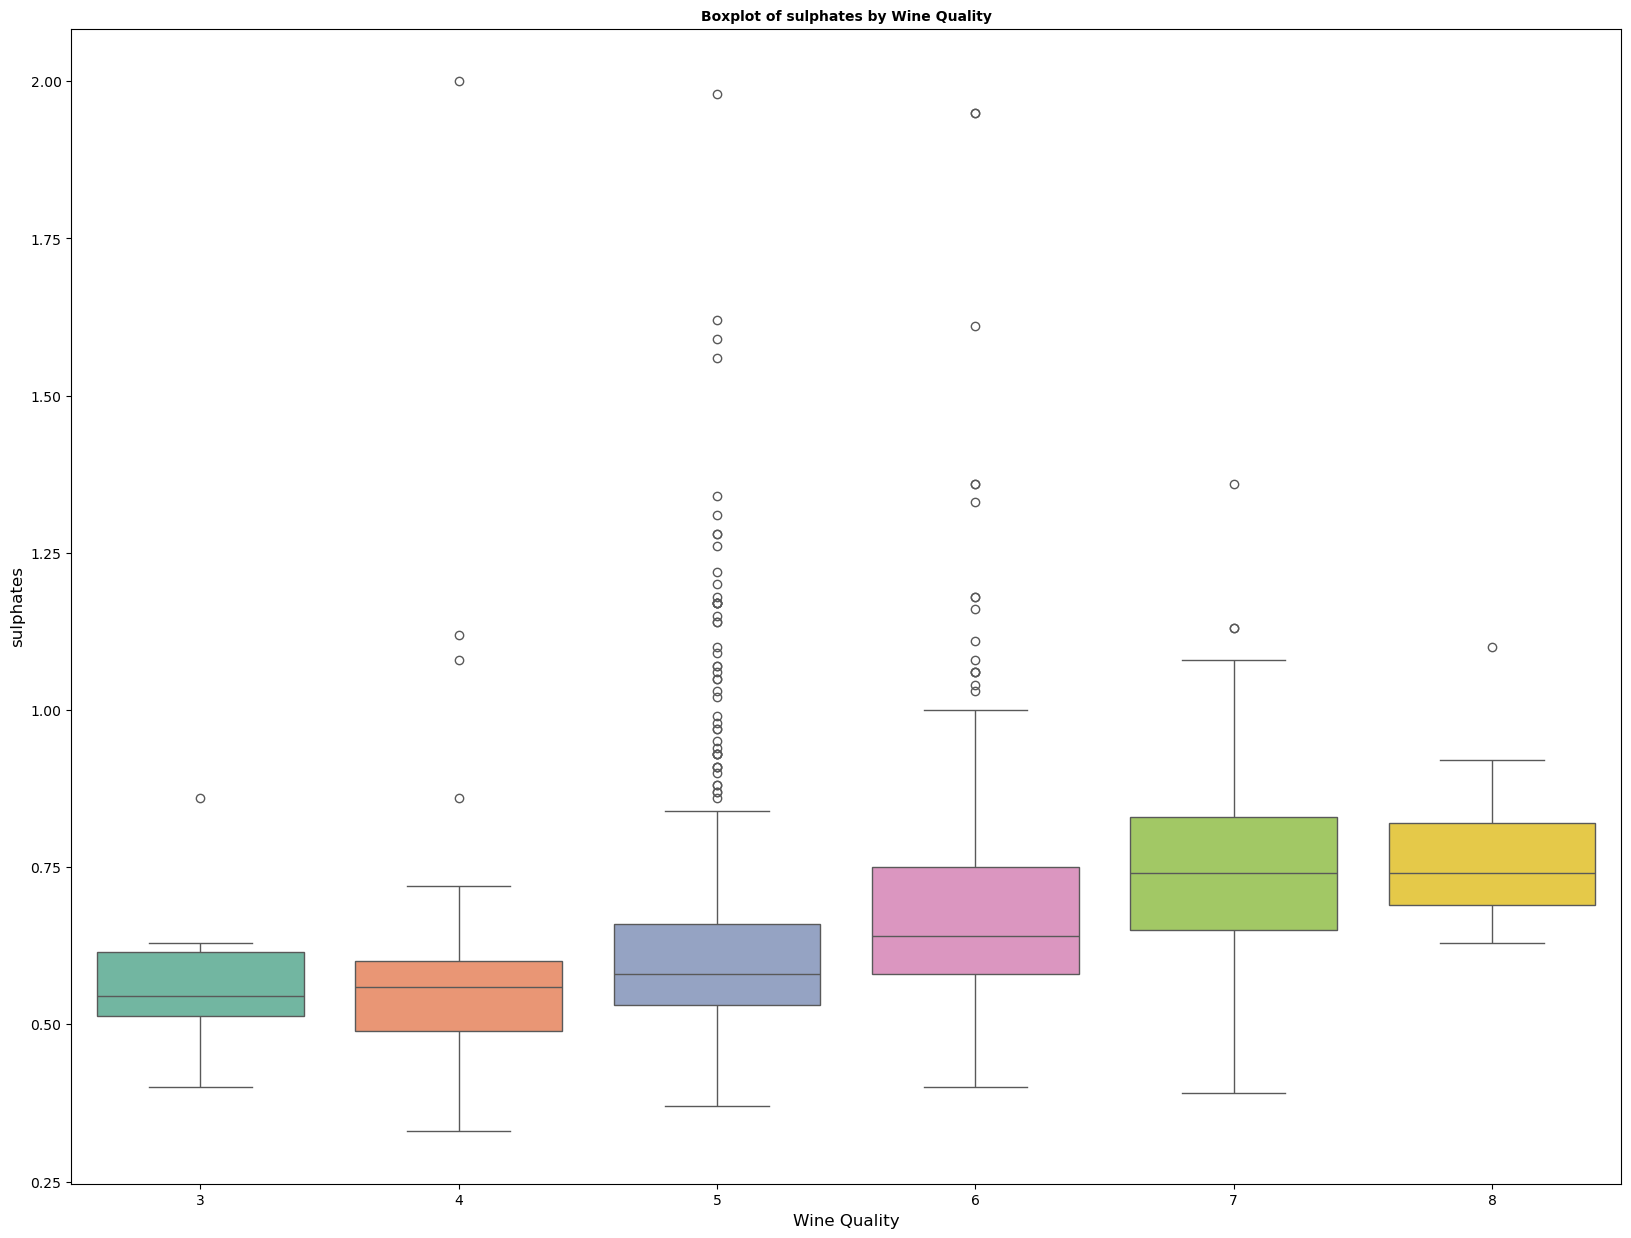

C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df, palette="Set2")


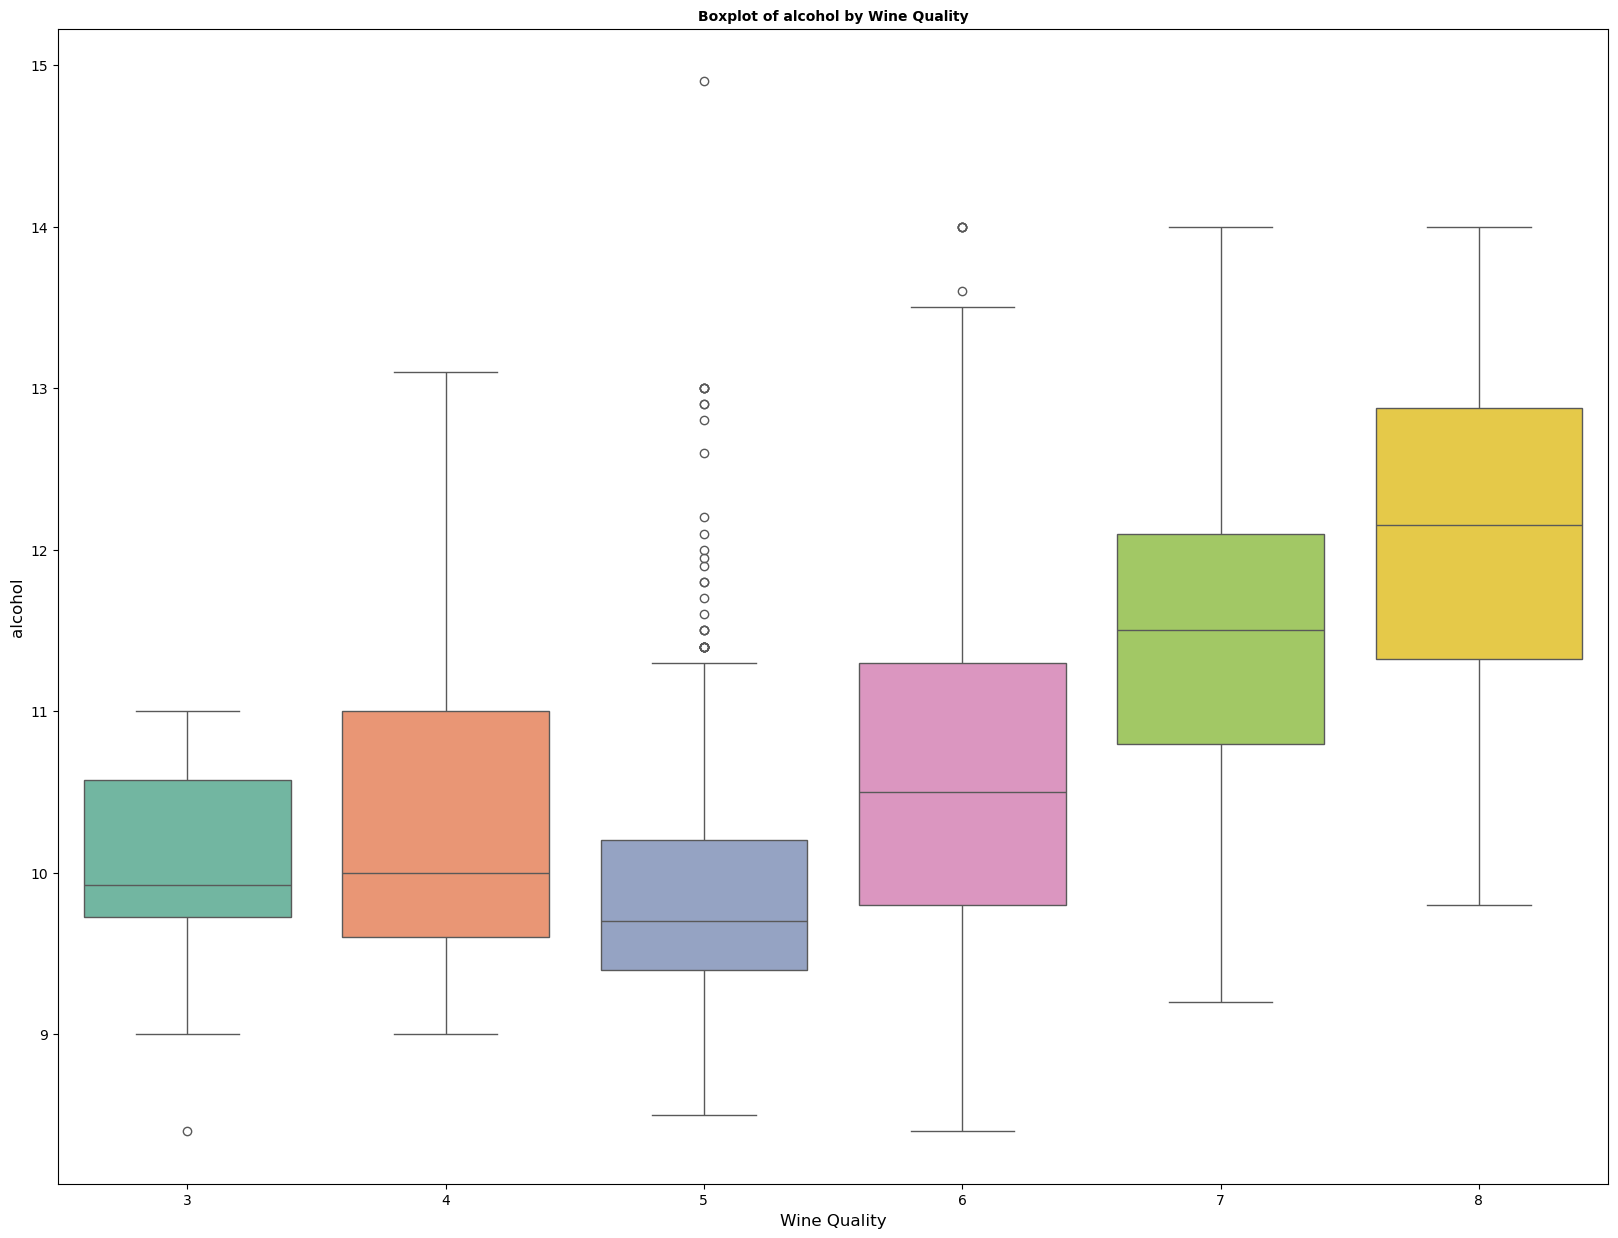

C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df_copy, palette="Set2")


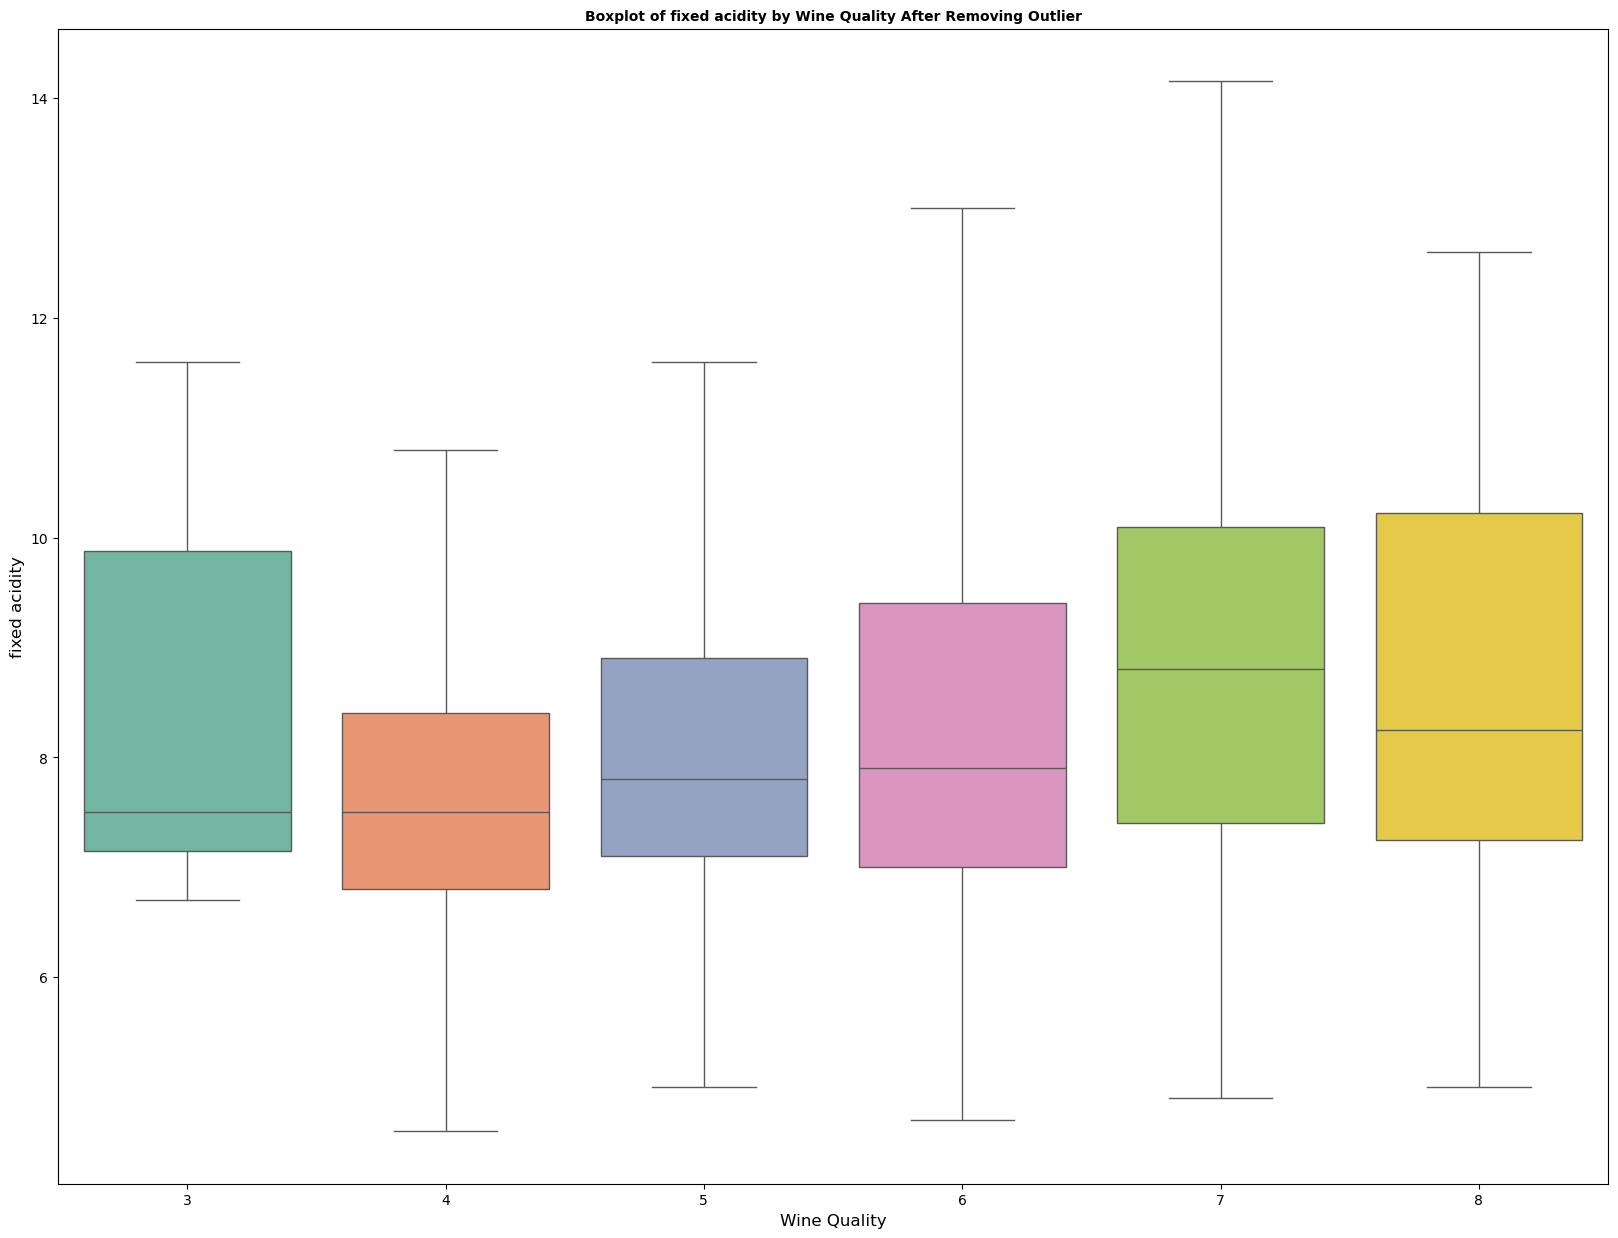

C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df_copy, palette="Set2")


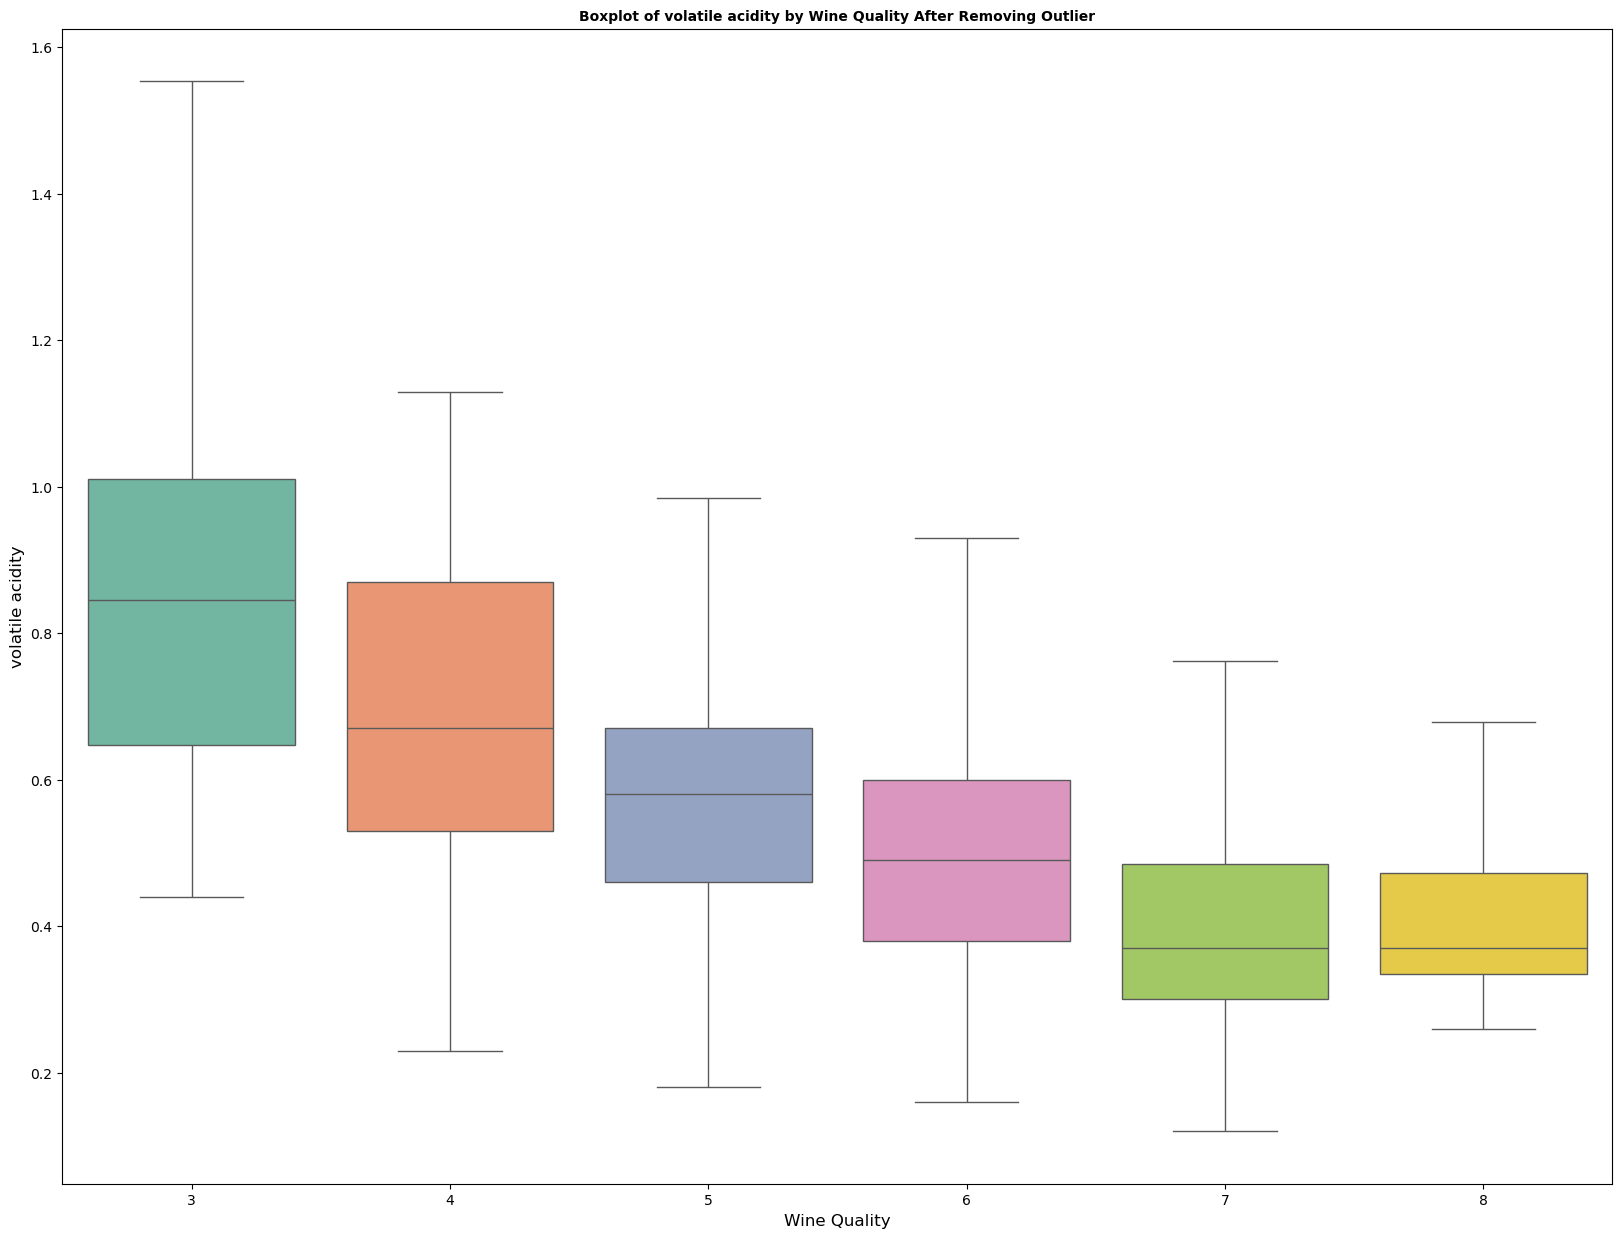

C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df_copy, palette="Set2")


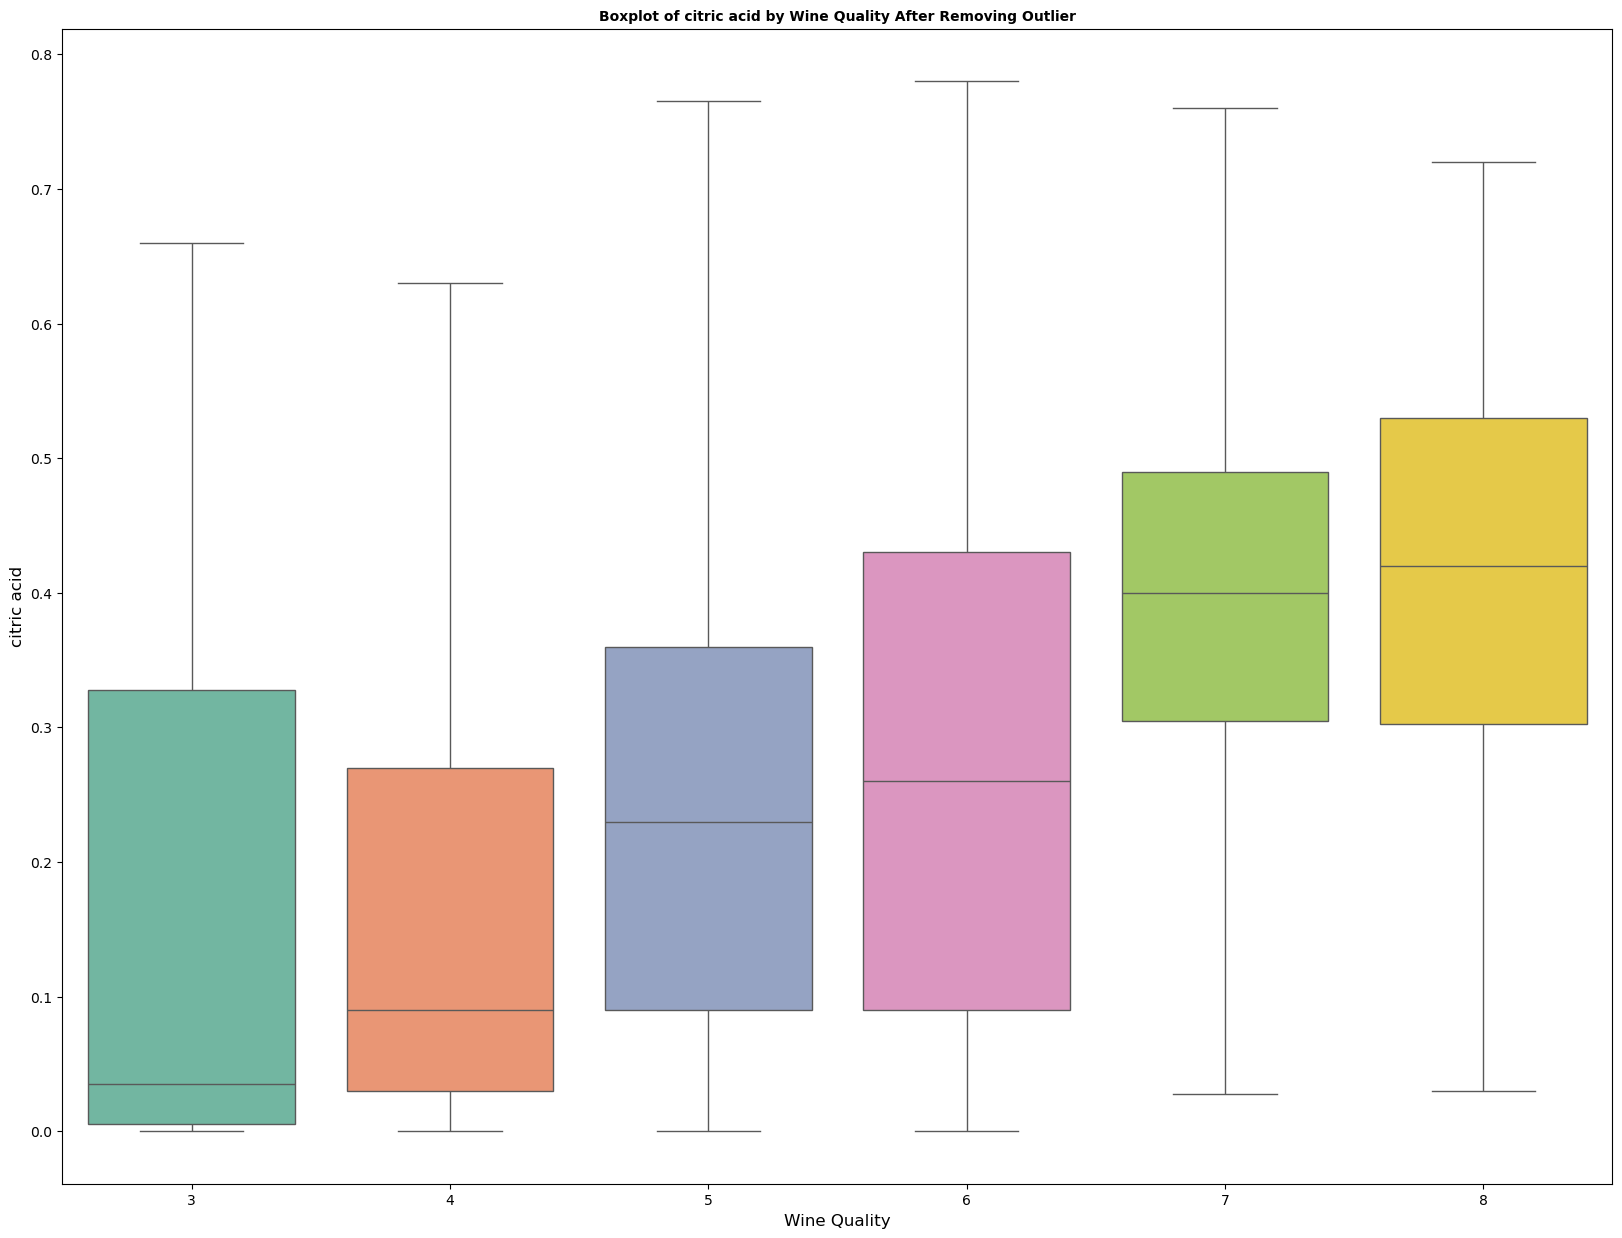

C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df_copy, palette="Set2")


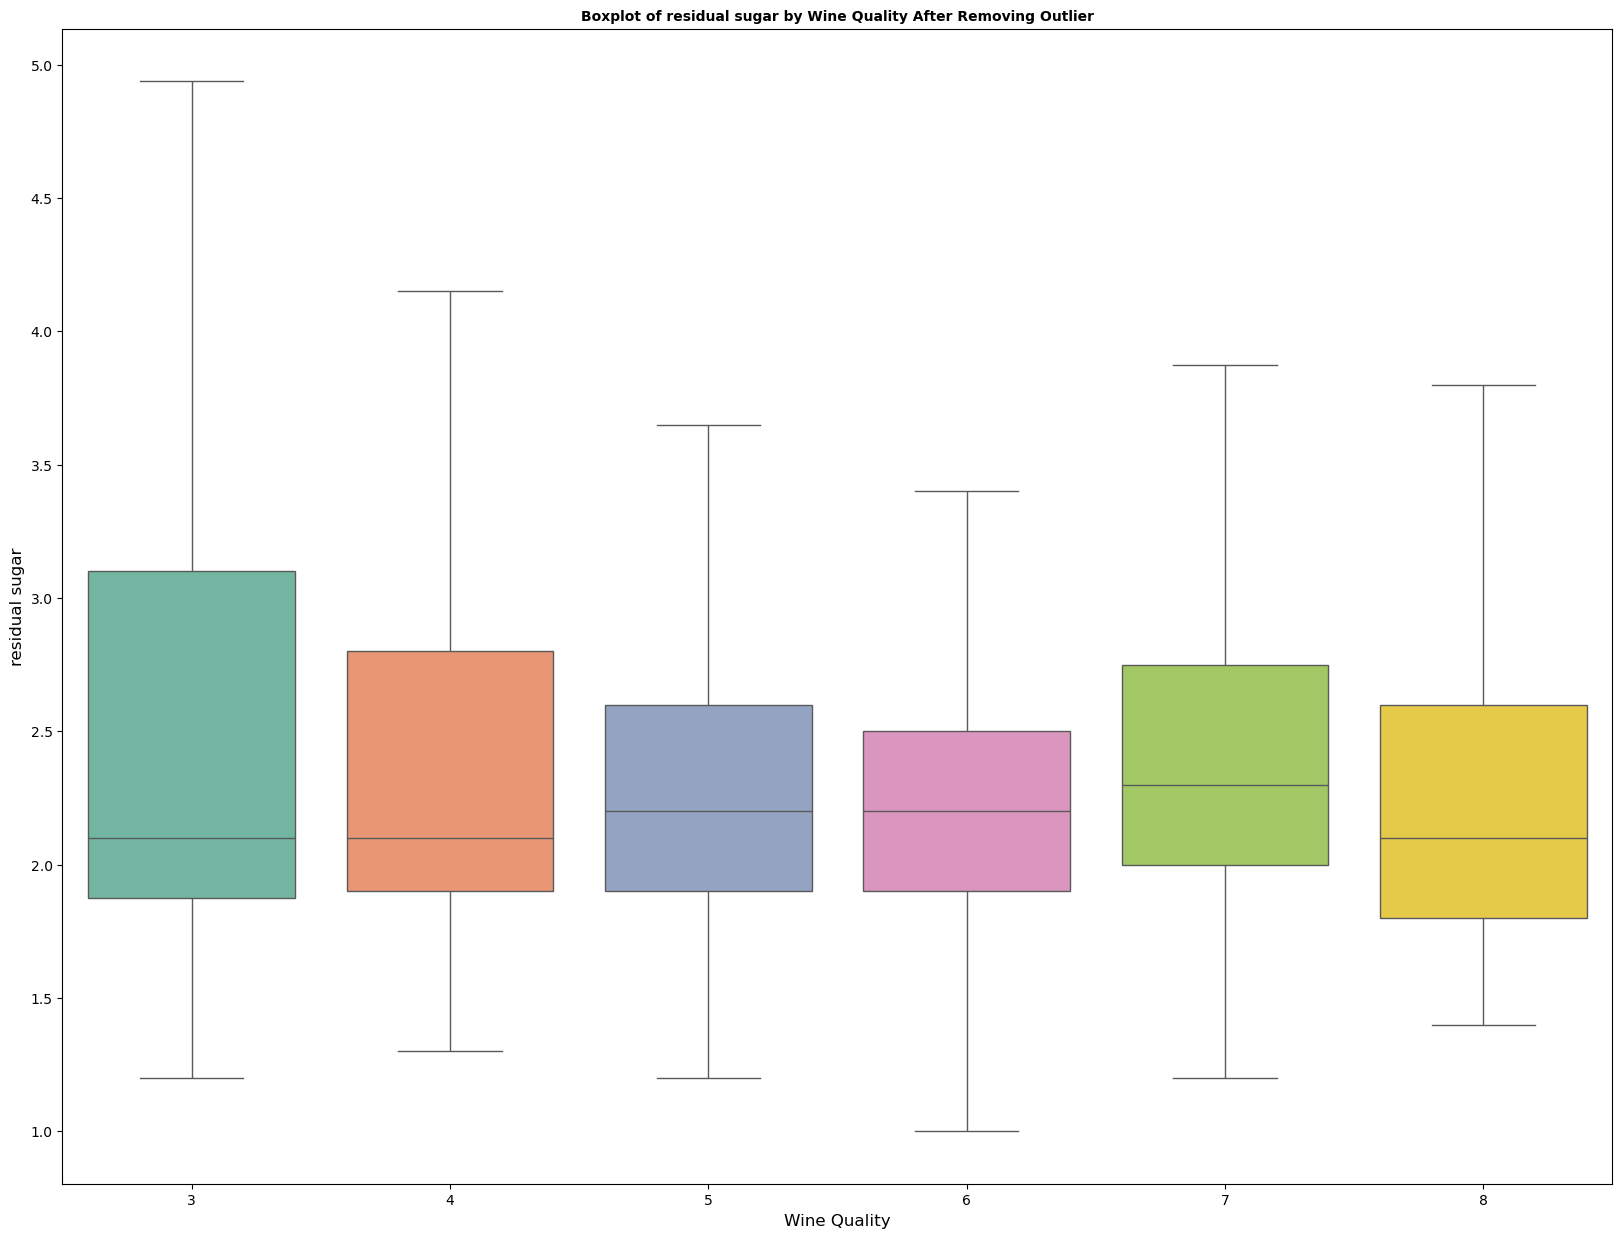

C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df_copy, palette="Set2")


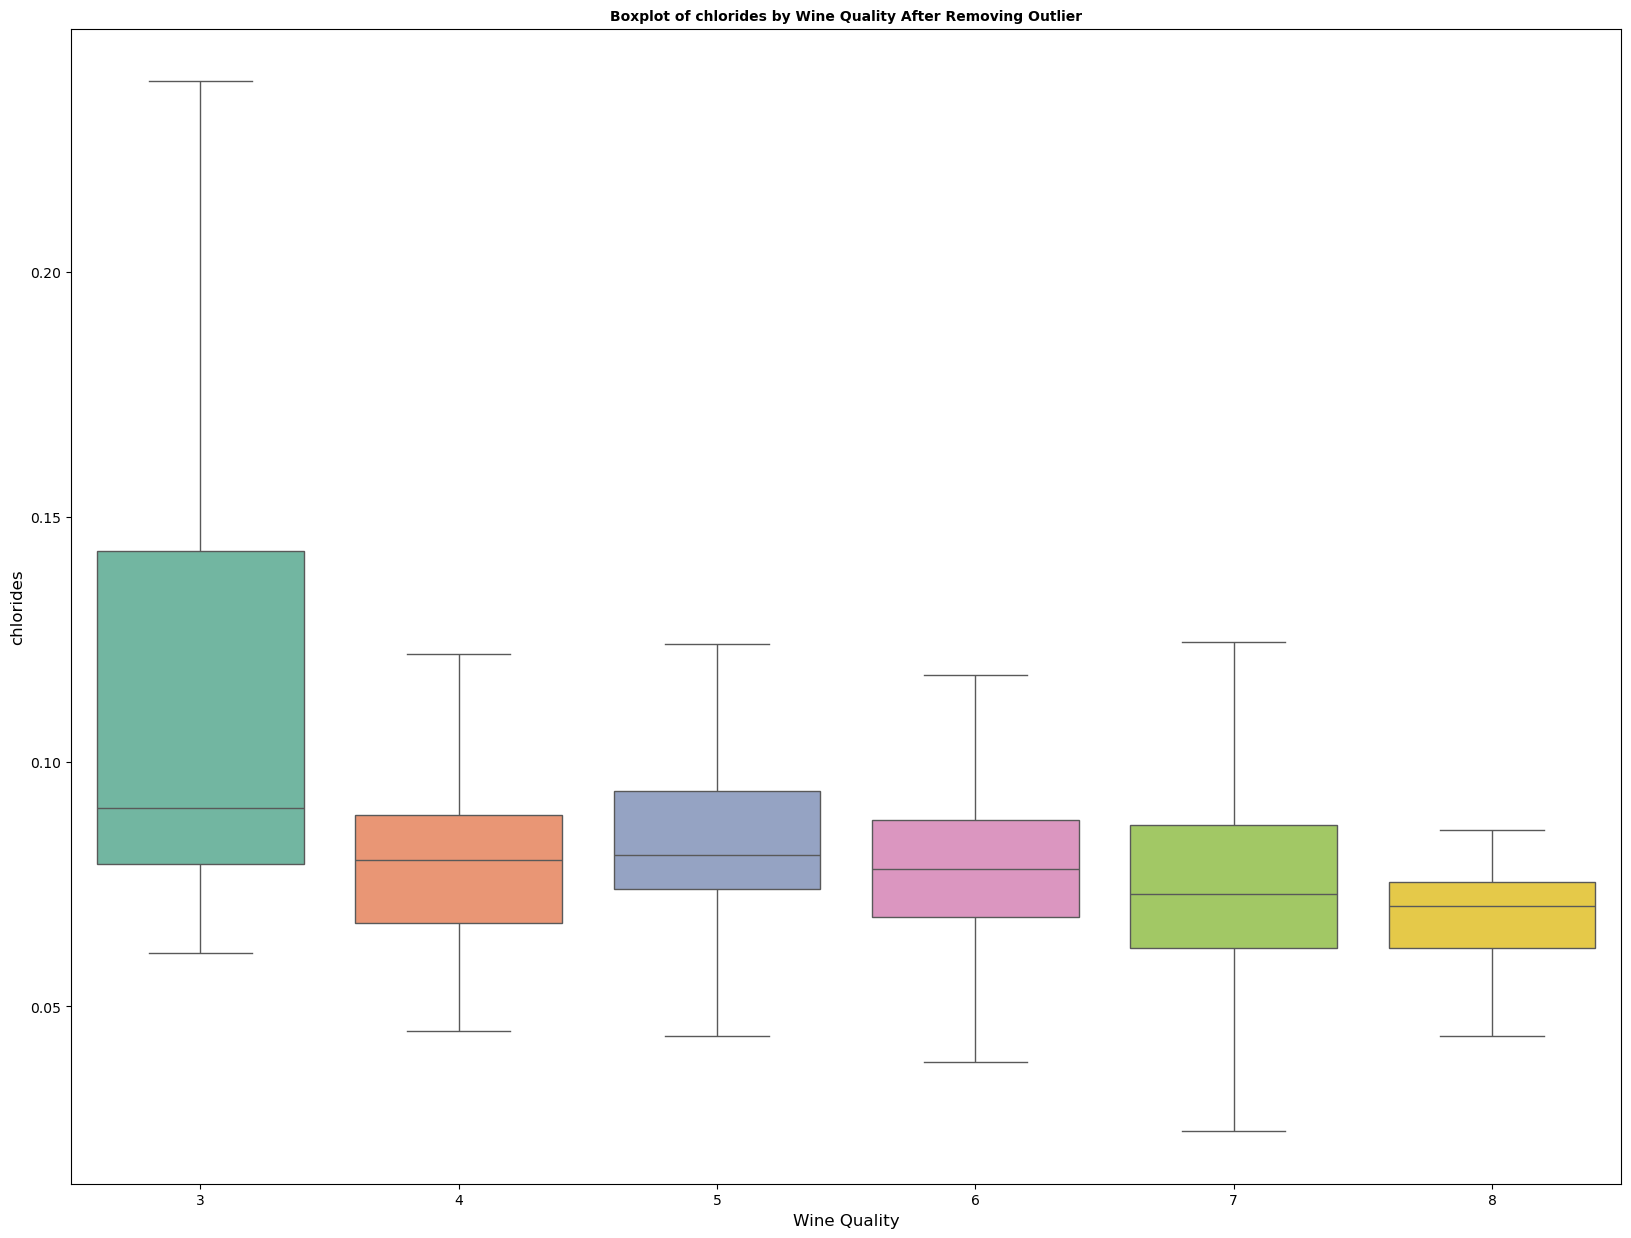

C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df_copy, palette="Set2")


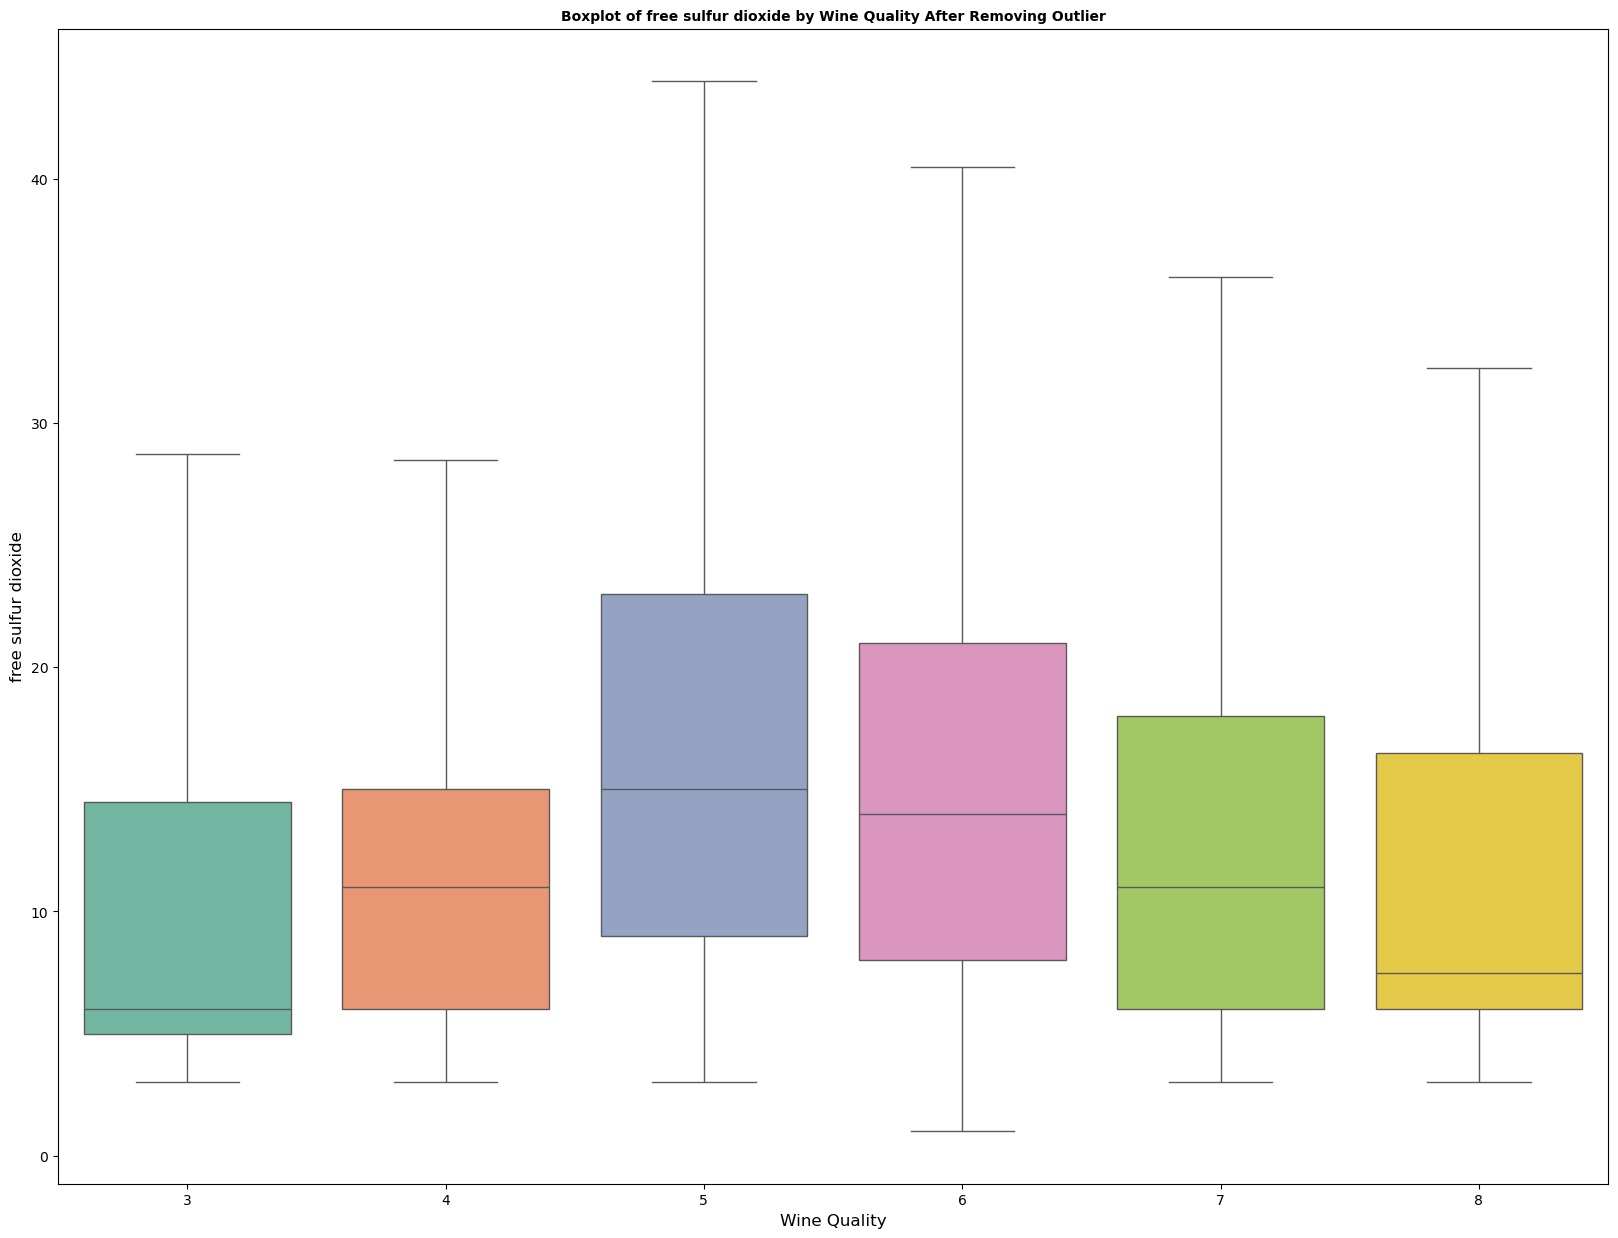

C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df_copy, palette="Set2")


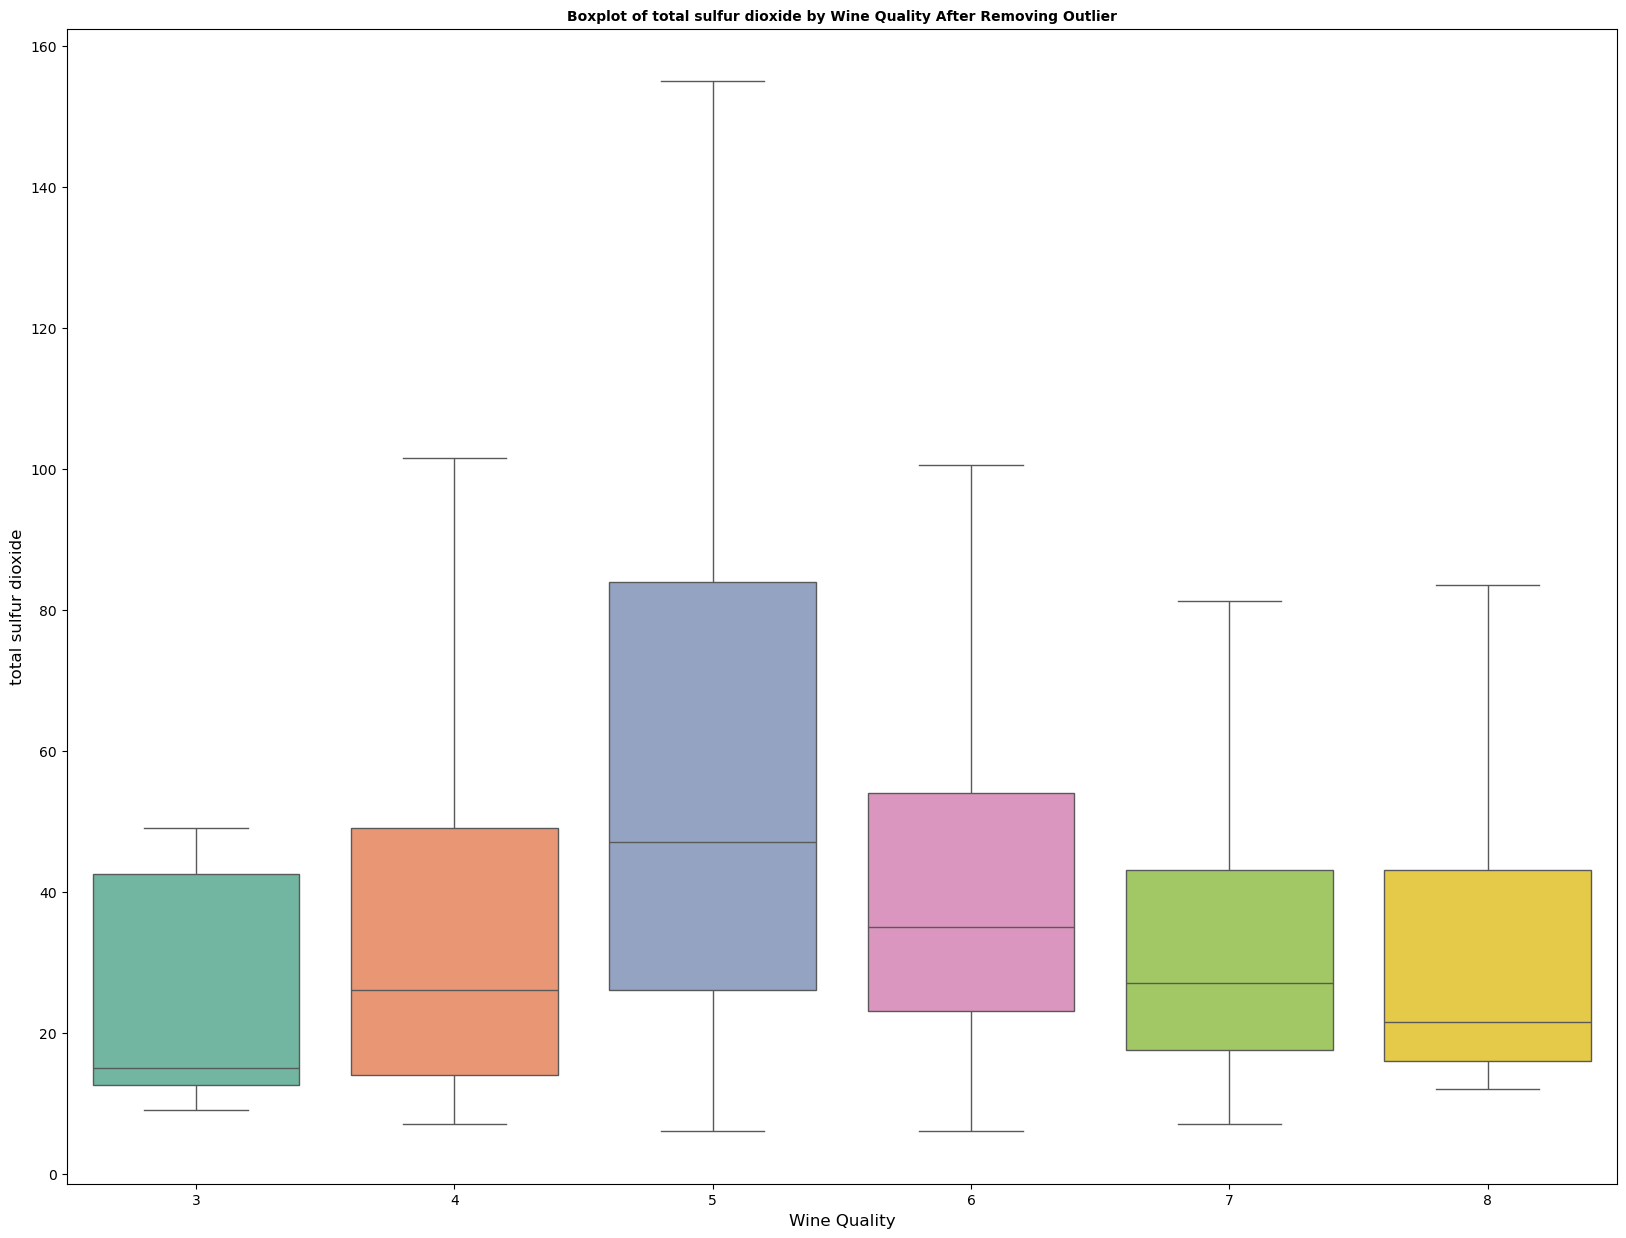

C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df_copy, palette="Set2")


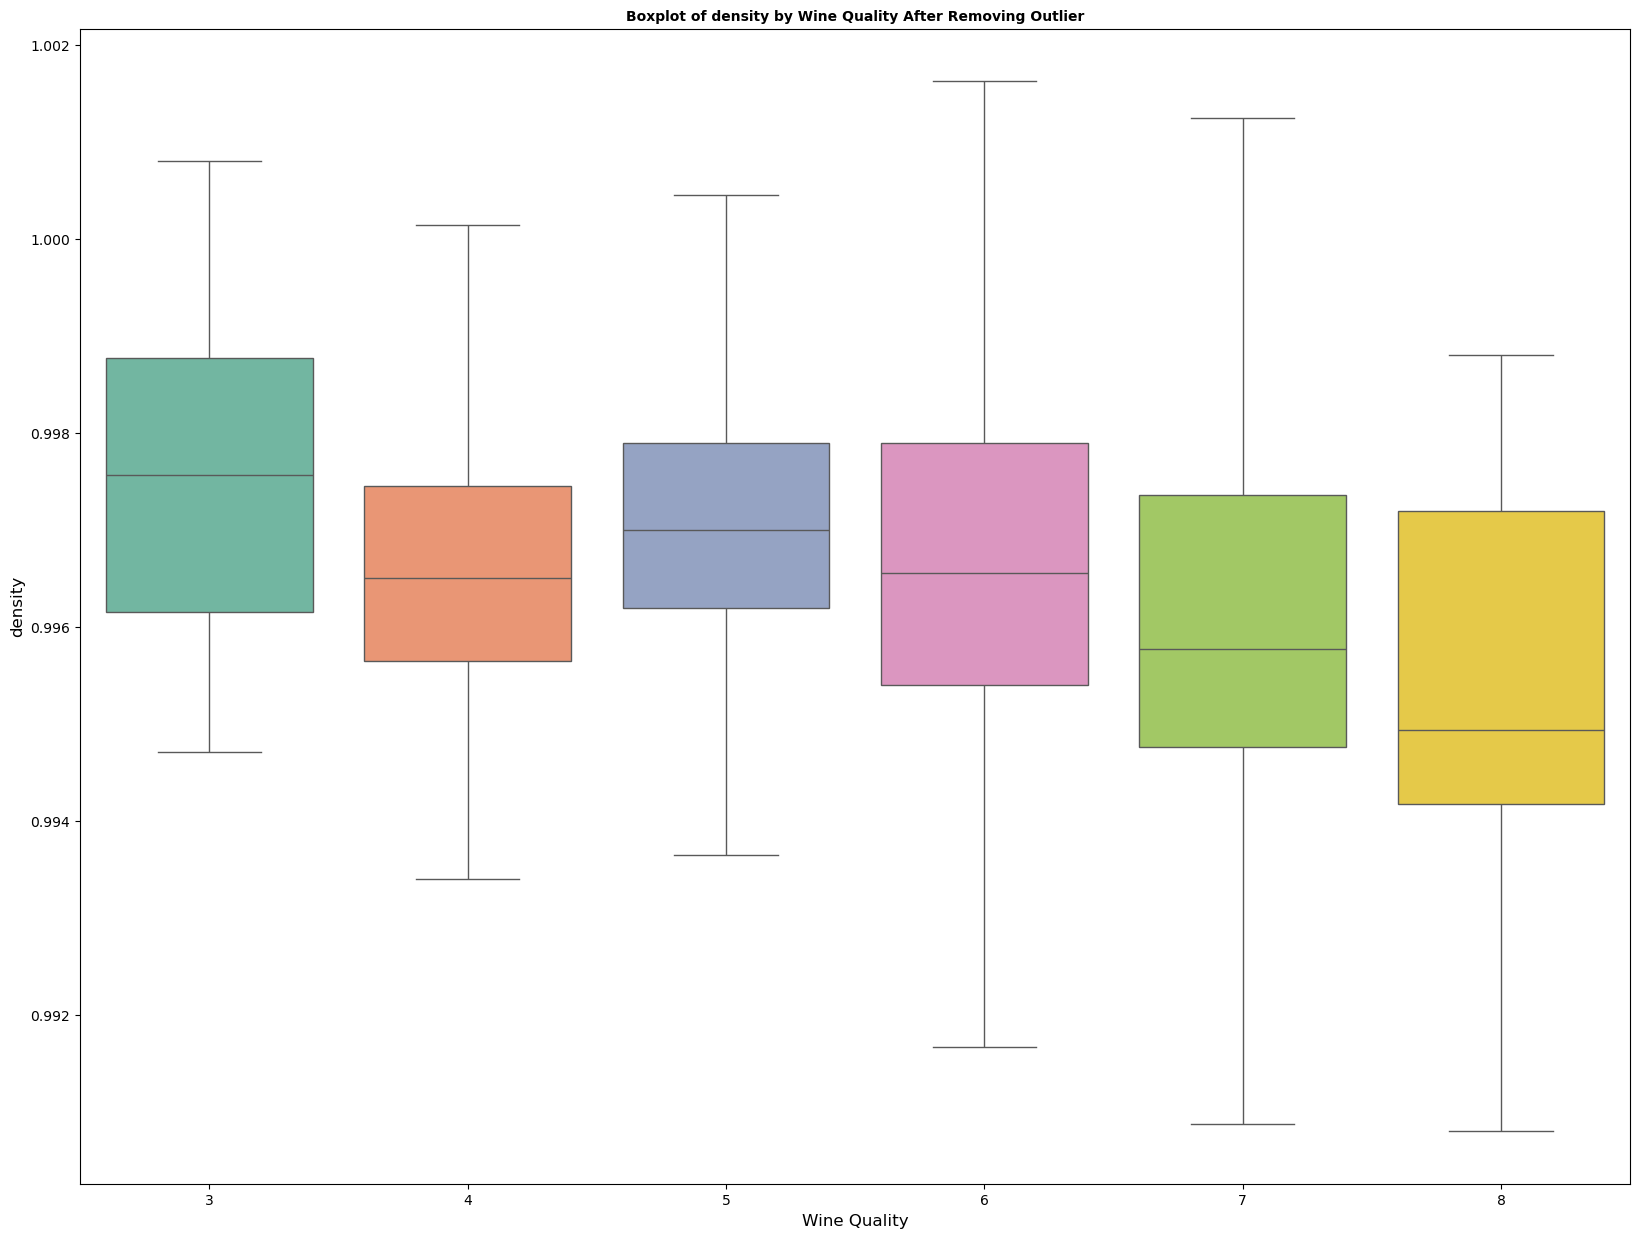

C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df_copy, palette="Set2")


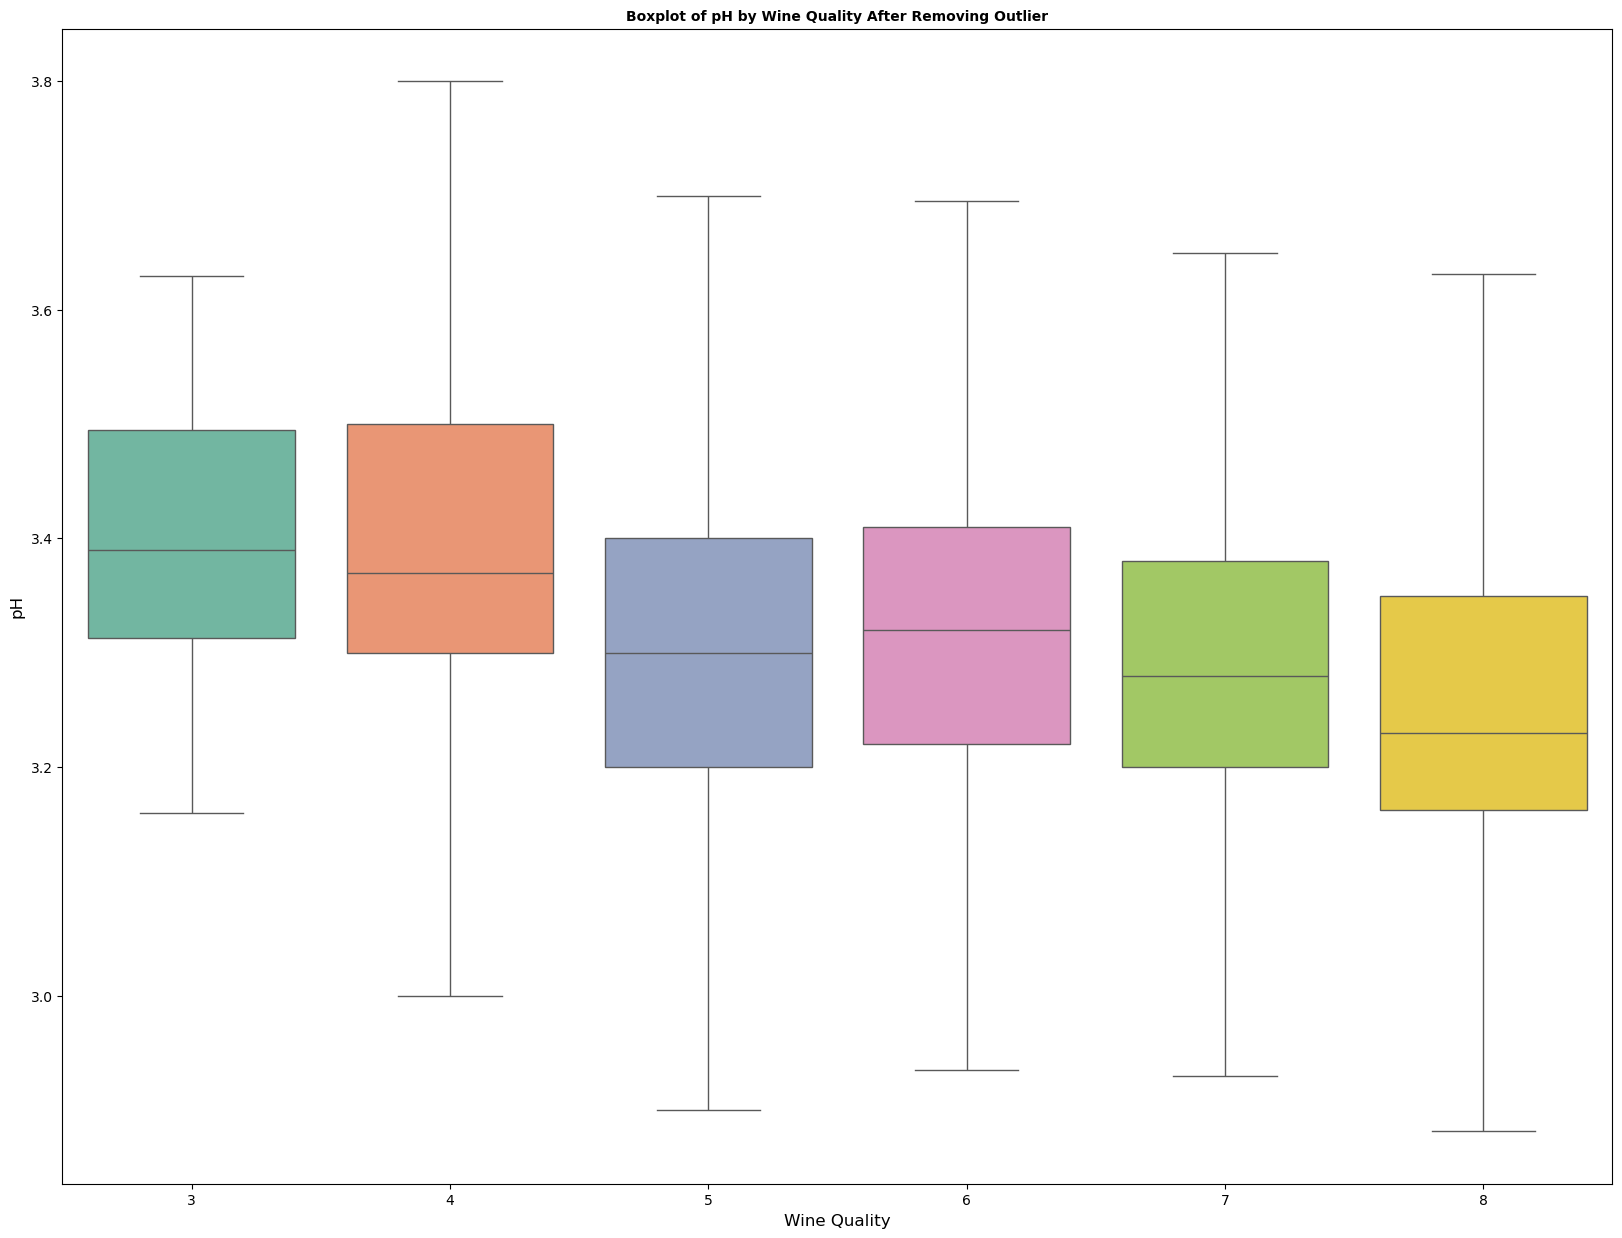

C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df_copy, palette="Set2")


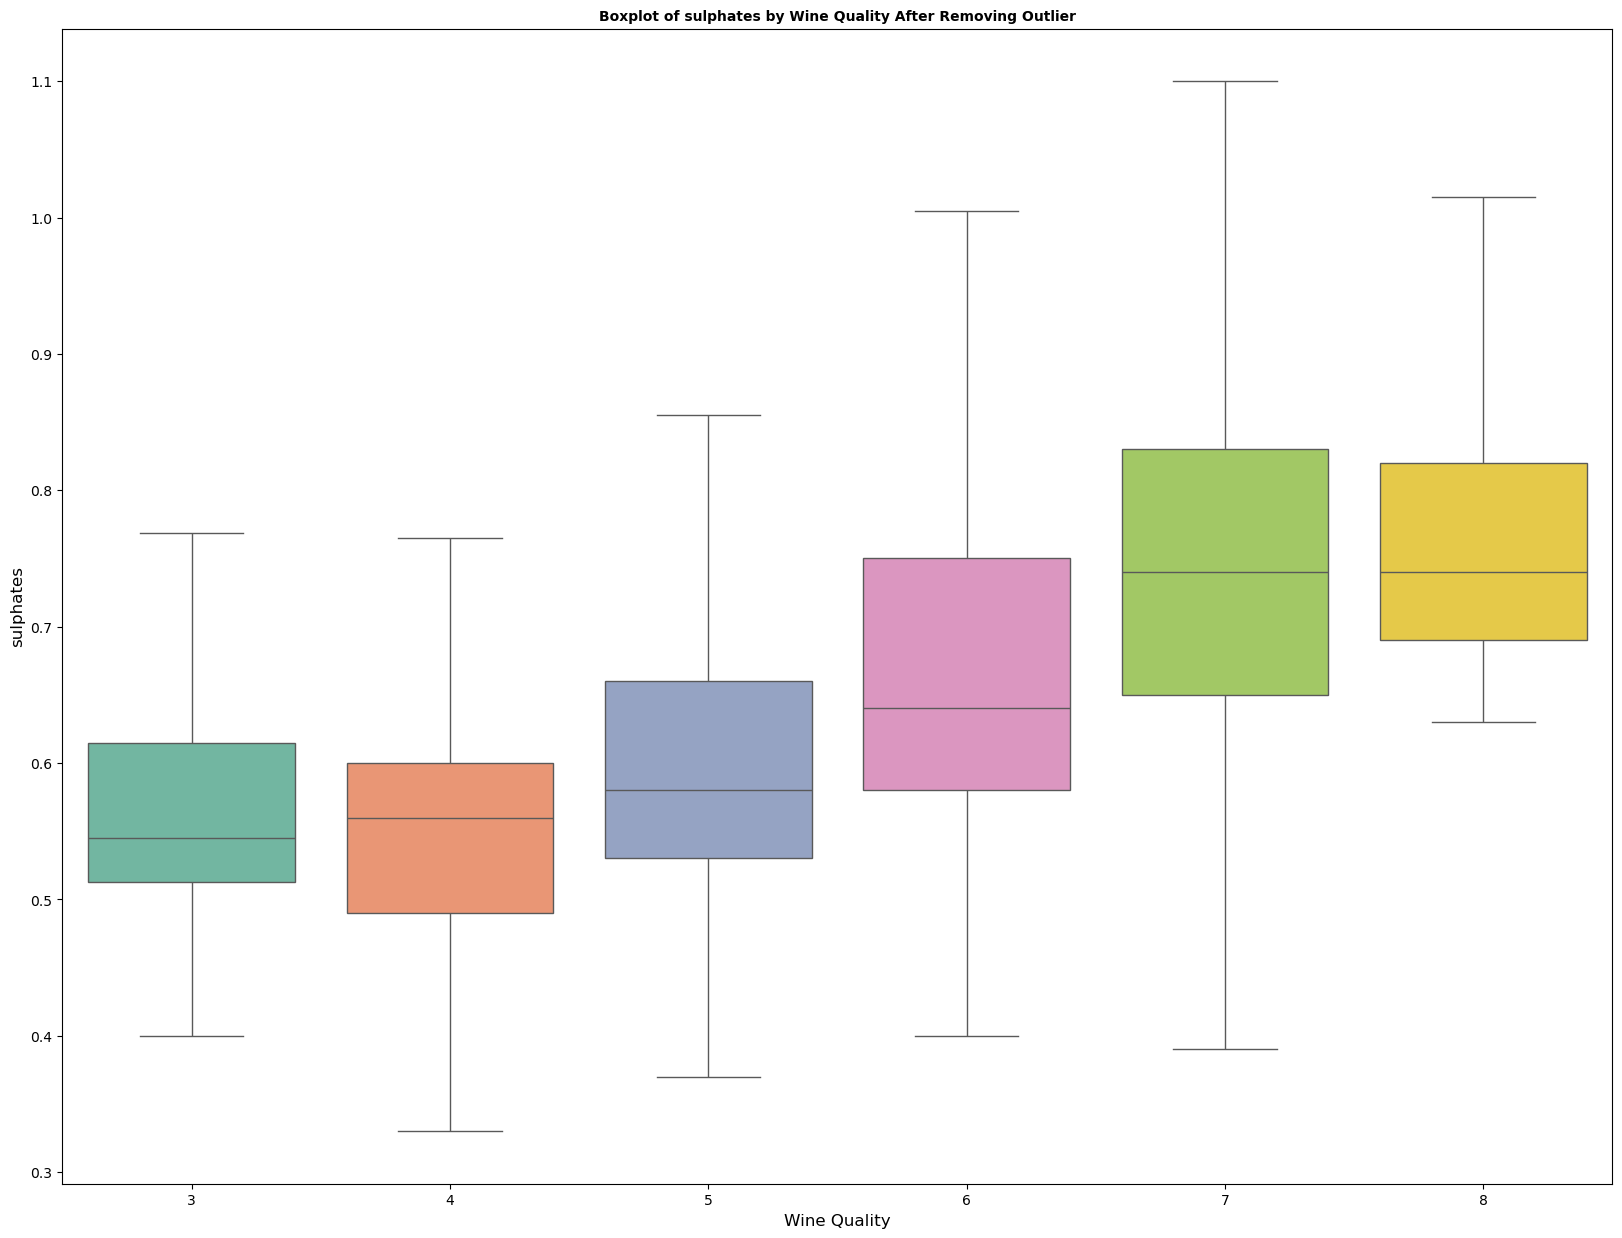

C:\Users\jueyo\AppData\Local\Temp\ipykernel_14308\1104134557.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="quality", y=feature, data=df_copy, palette="Set2")


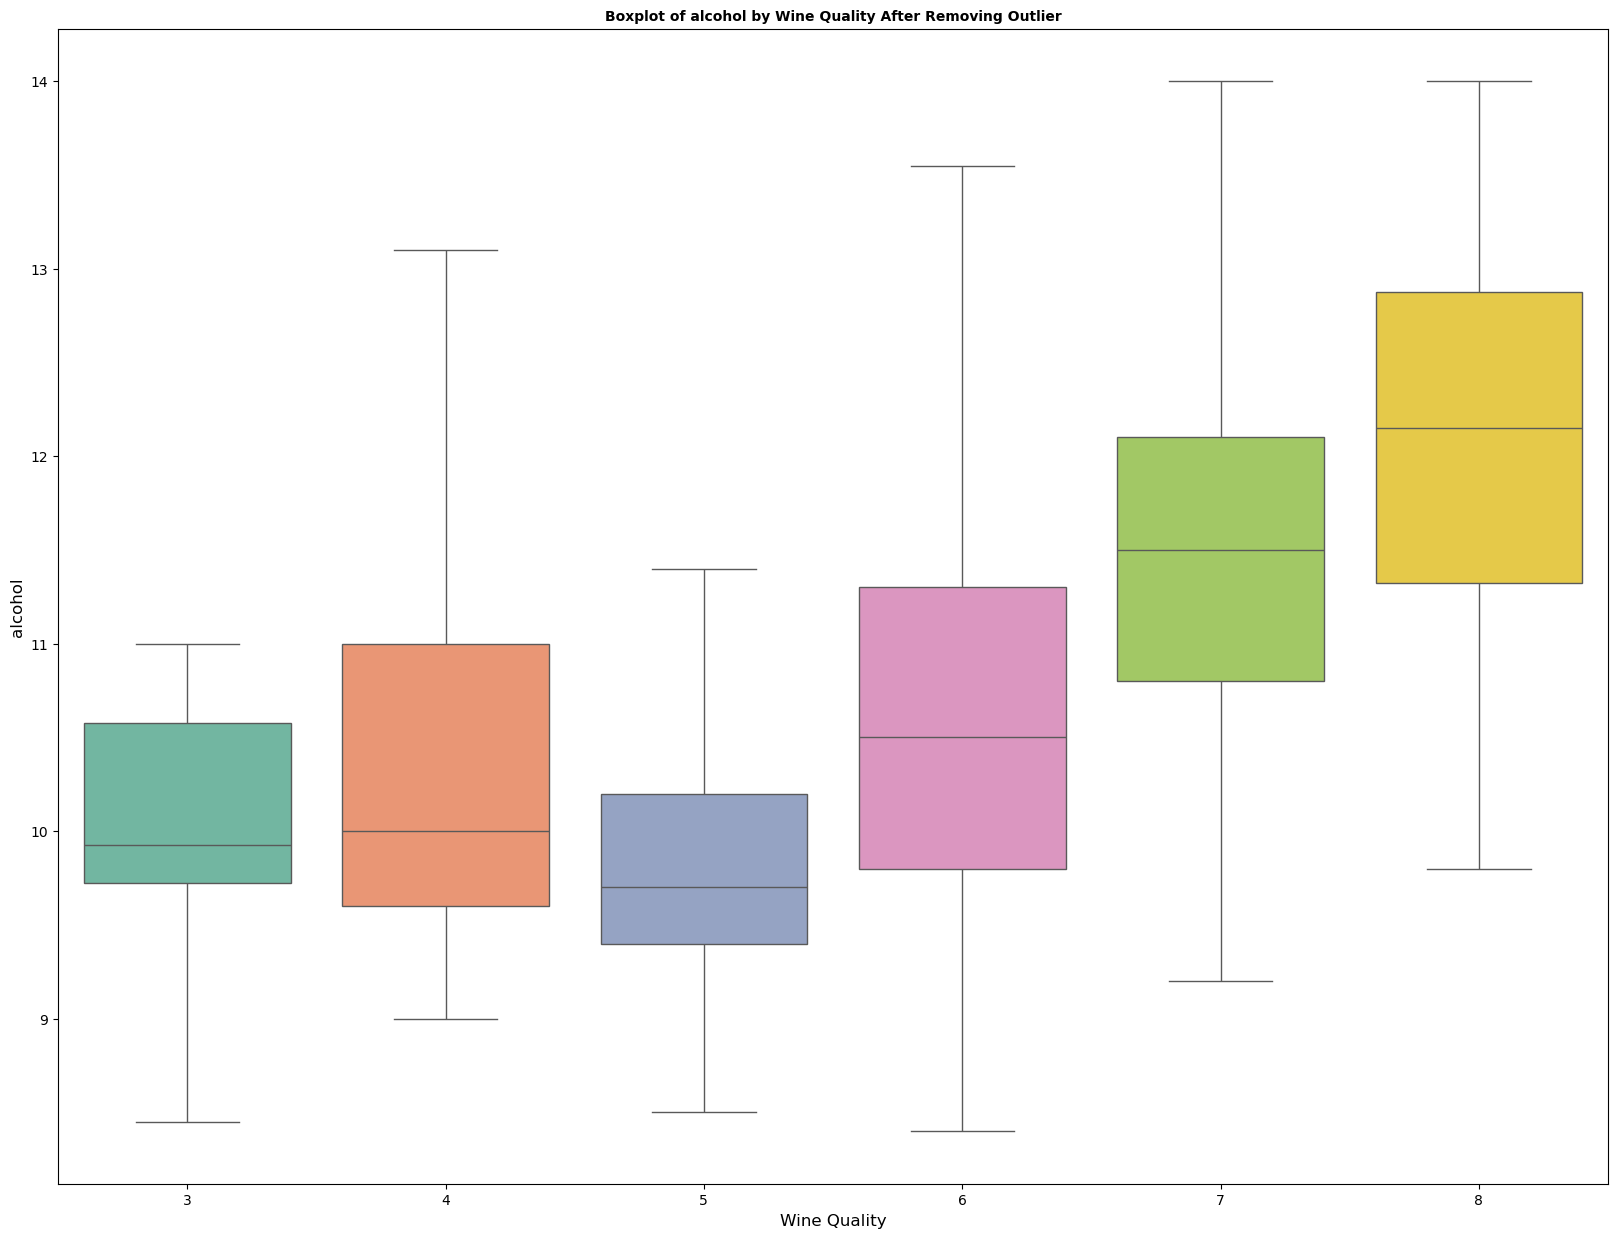

In [15]:
"""
Apply the the outlier procedure
"""
wine_data_no_outlier = outlier_procedure(wine_data_no_missingvalue)

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70       0.0000            1.90      0.076   
1            7.8              0.88       0.0000            2.60      0.098   
2            7.8              0.76       0.0400            2.30      0.092   
3           11.2              0.28       0.5600            1.90      0.075   
4            7.4              0.70       0.0000            1.90      0.076   
5            7.4              0.66       0.0000            1.80      0.075   
6            7.9              0.60       0.0600            1.60      0.069   
7            7.3              0.65       0.0275            1.20      0.065   
8            7.8              0.58       0.0275            2.00      0.073   
9            7.5              0.50       0.3600            3.65      0.071   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0

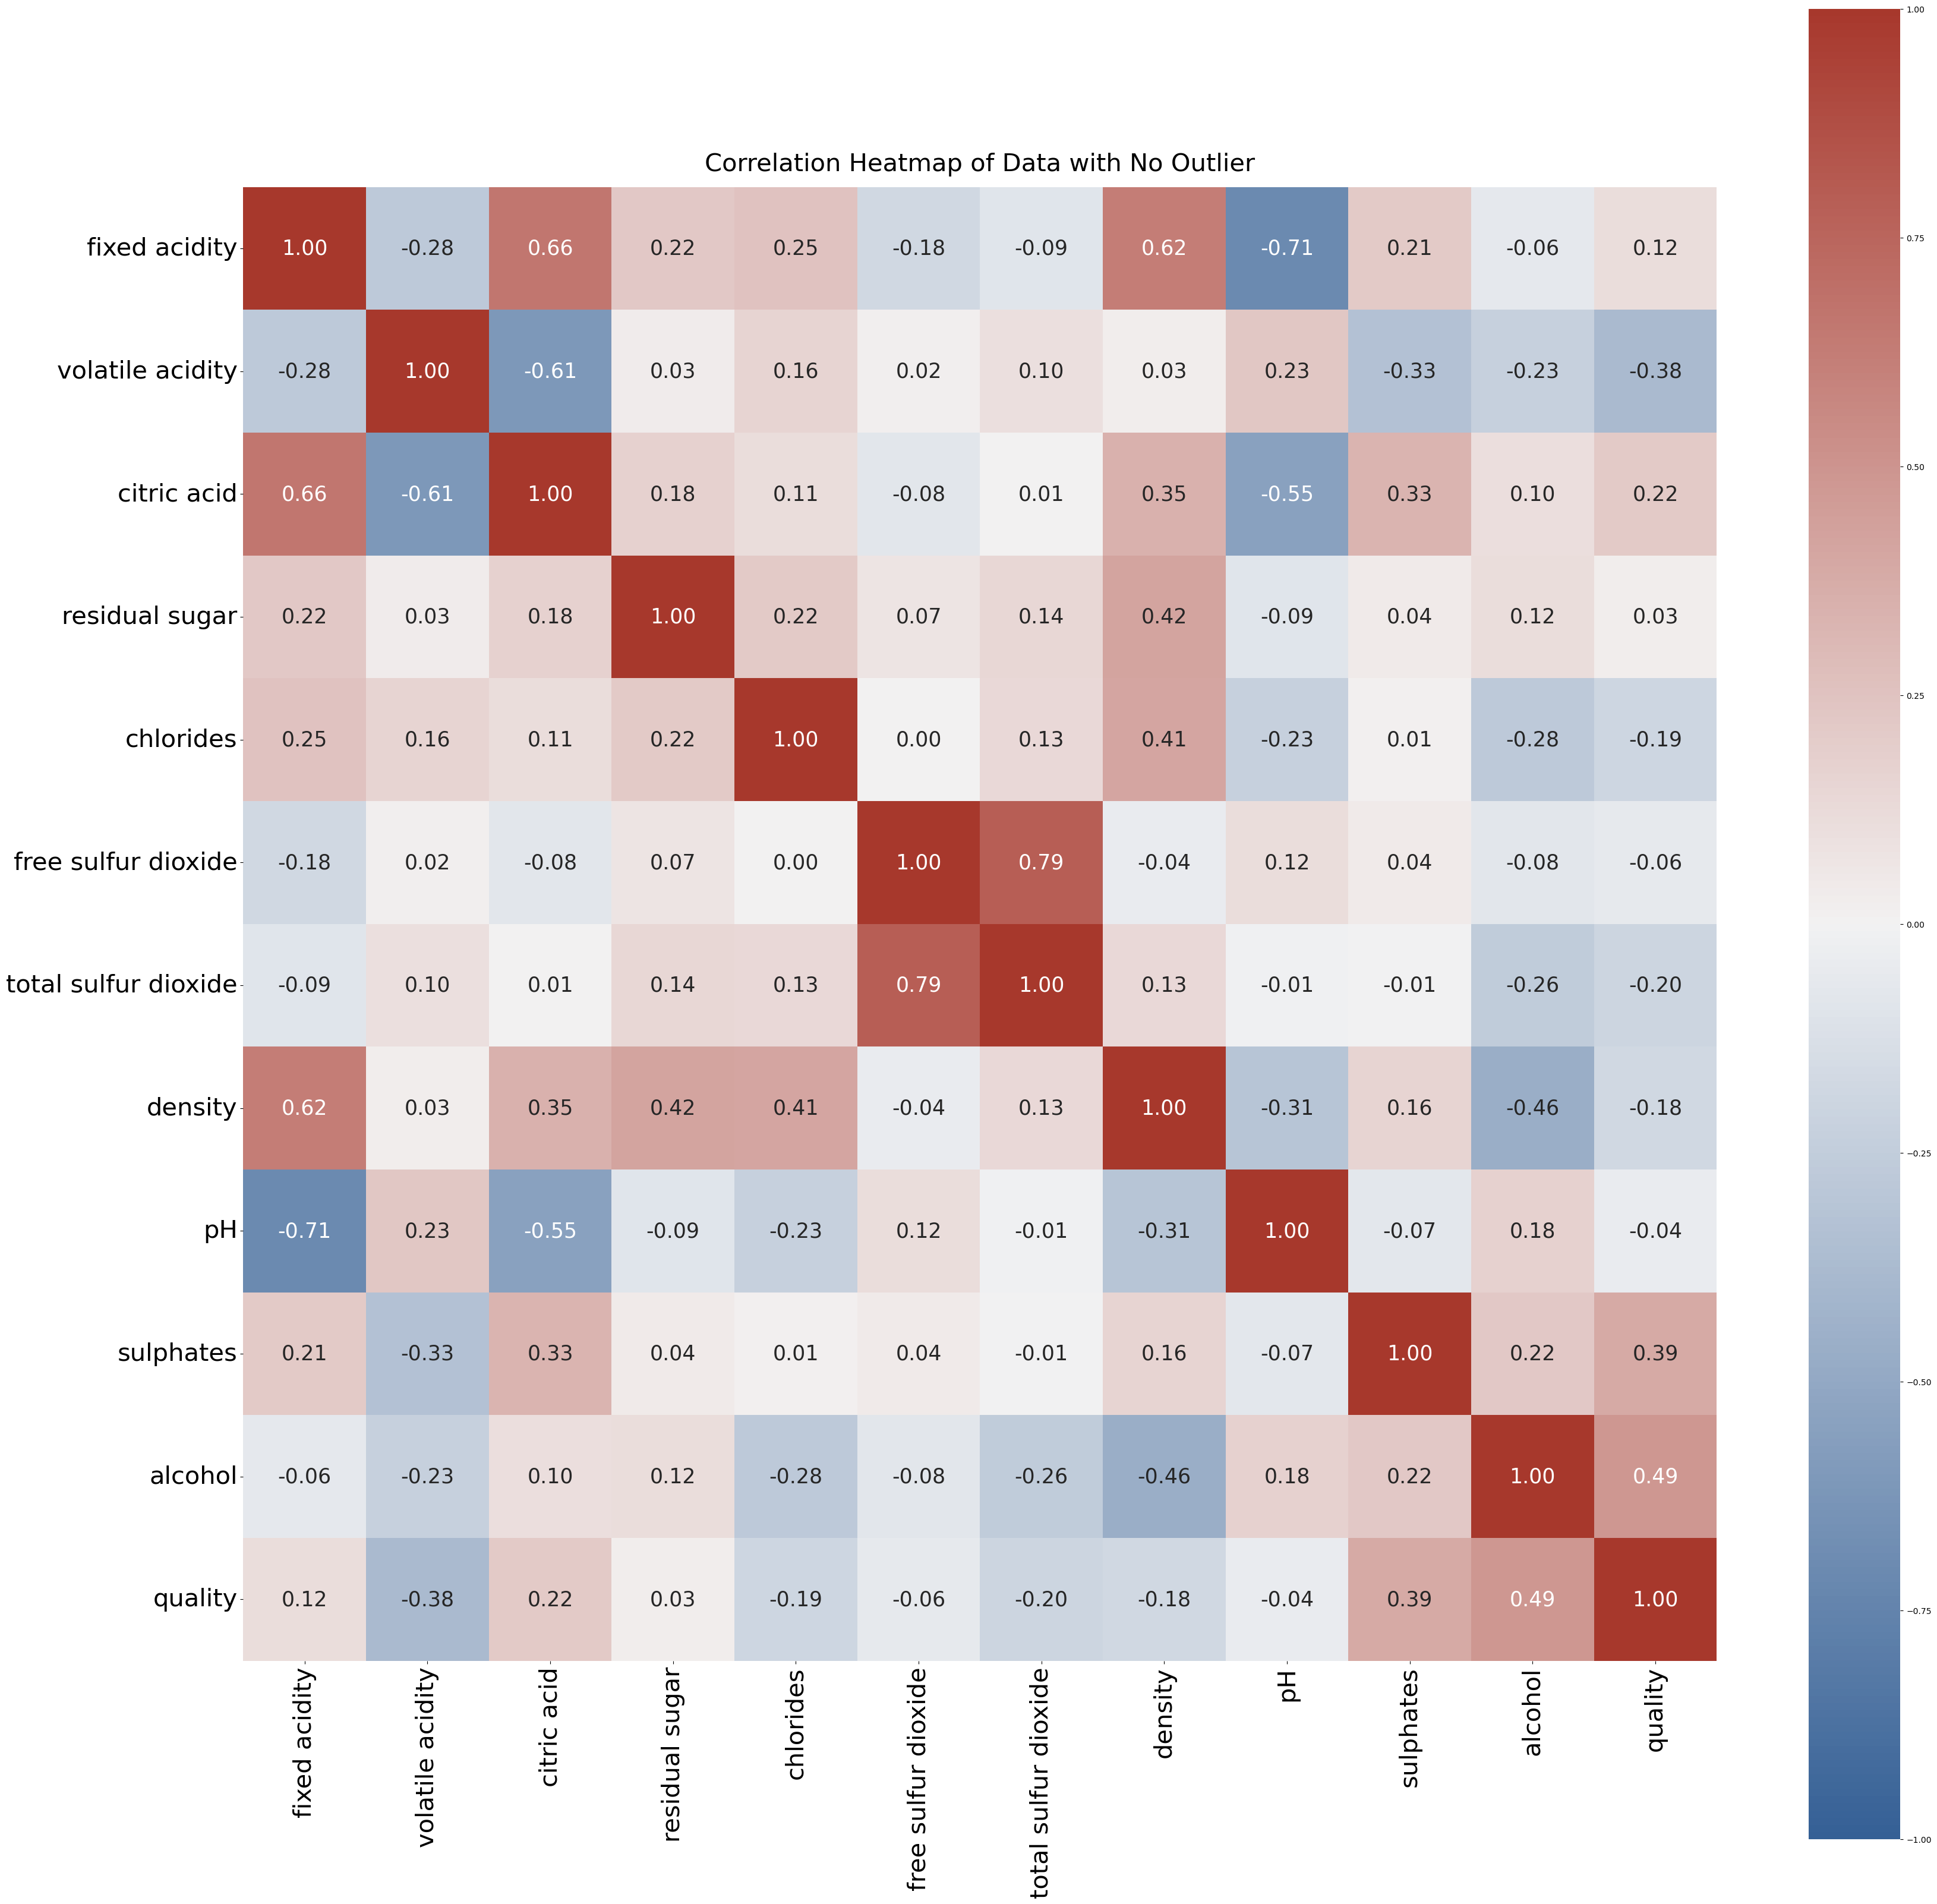

In [63]:
# covariance matrix
print(wine_data_no_outlier.head(10))

#cov_matrix= wine_data_no_outlier.astype(float).corr()
cov_matrix= wine_data_no_outlier.corr(method='spearman')

cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)

plt.figure(figsize=(40,40))
sns.heatmap(cov_matrix,  center=0, annot=True,fmt='.2f', square=True, cmap=cmap,vmin=-1, vmax=1,annot_kws={"size": 25})
plt.xticks(fontsize=30,rotation=90)
plt.yticks(fontsize=30,rotation=0)
plt.title('Correlation Heatmap of Data with No Outlier', fontsize=30, pad=20) 
plt.show()



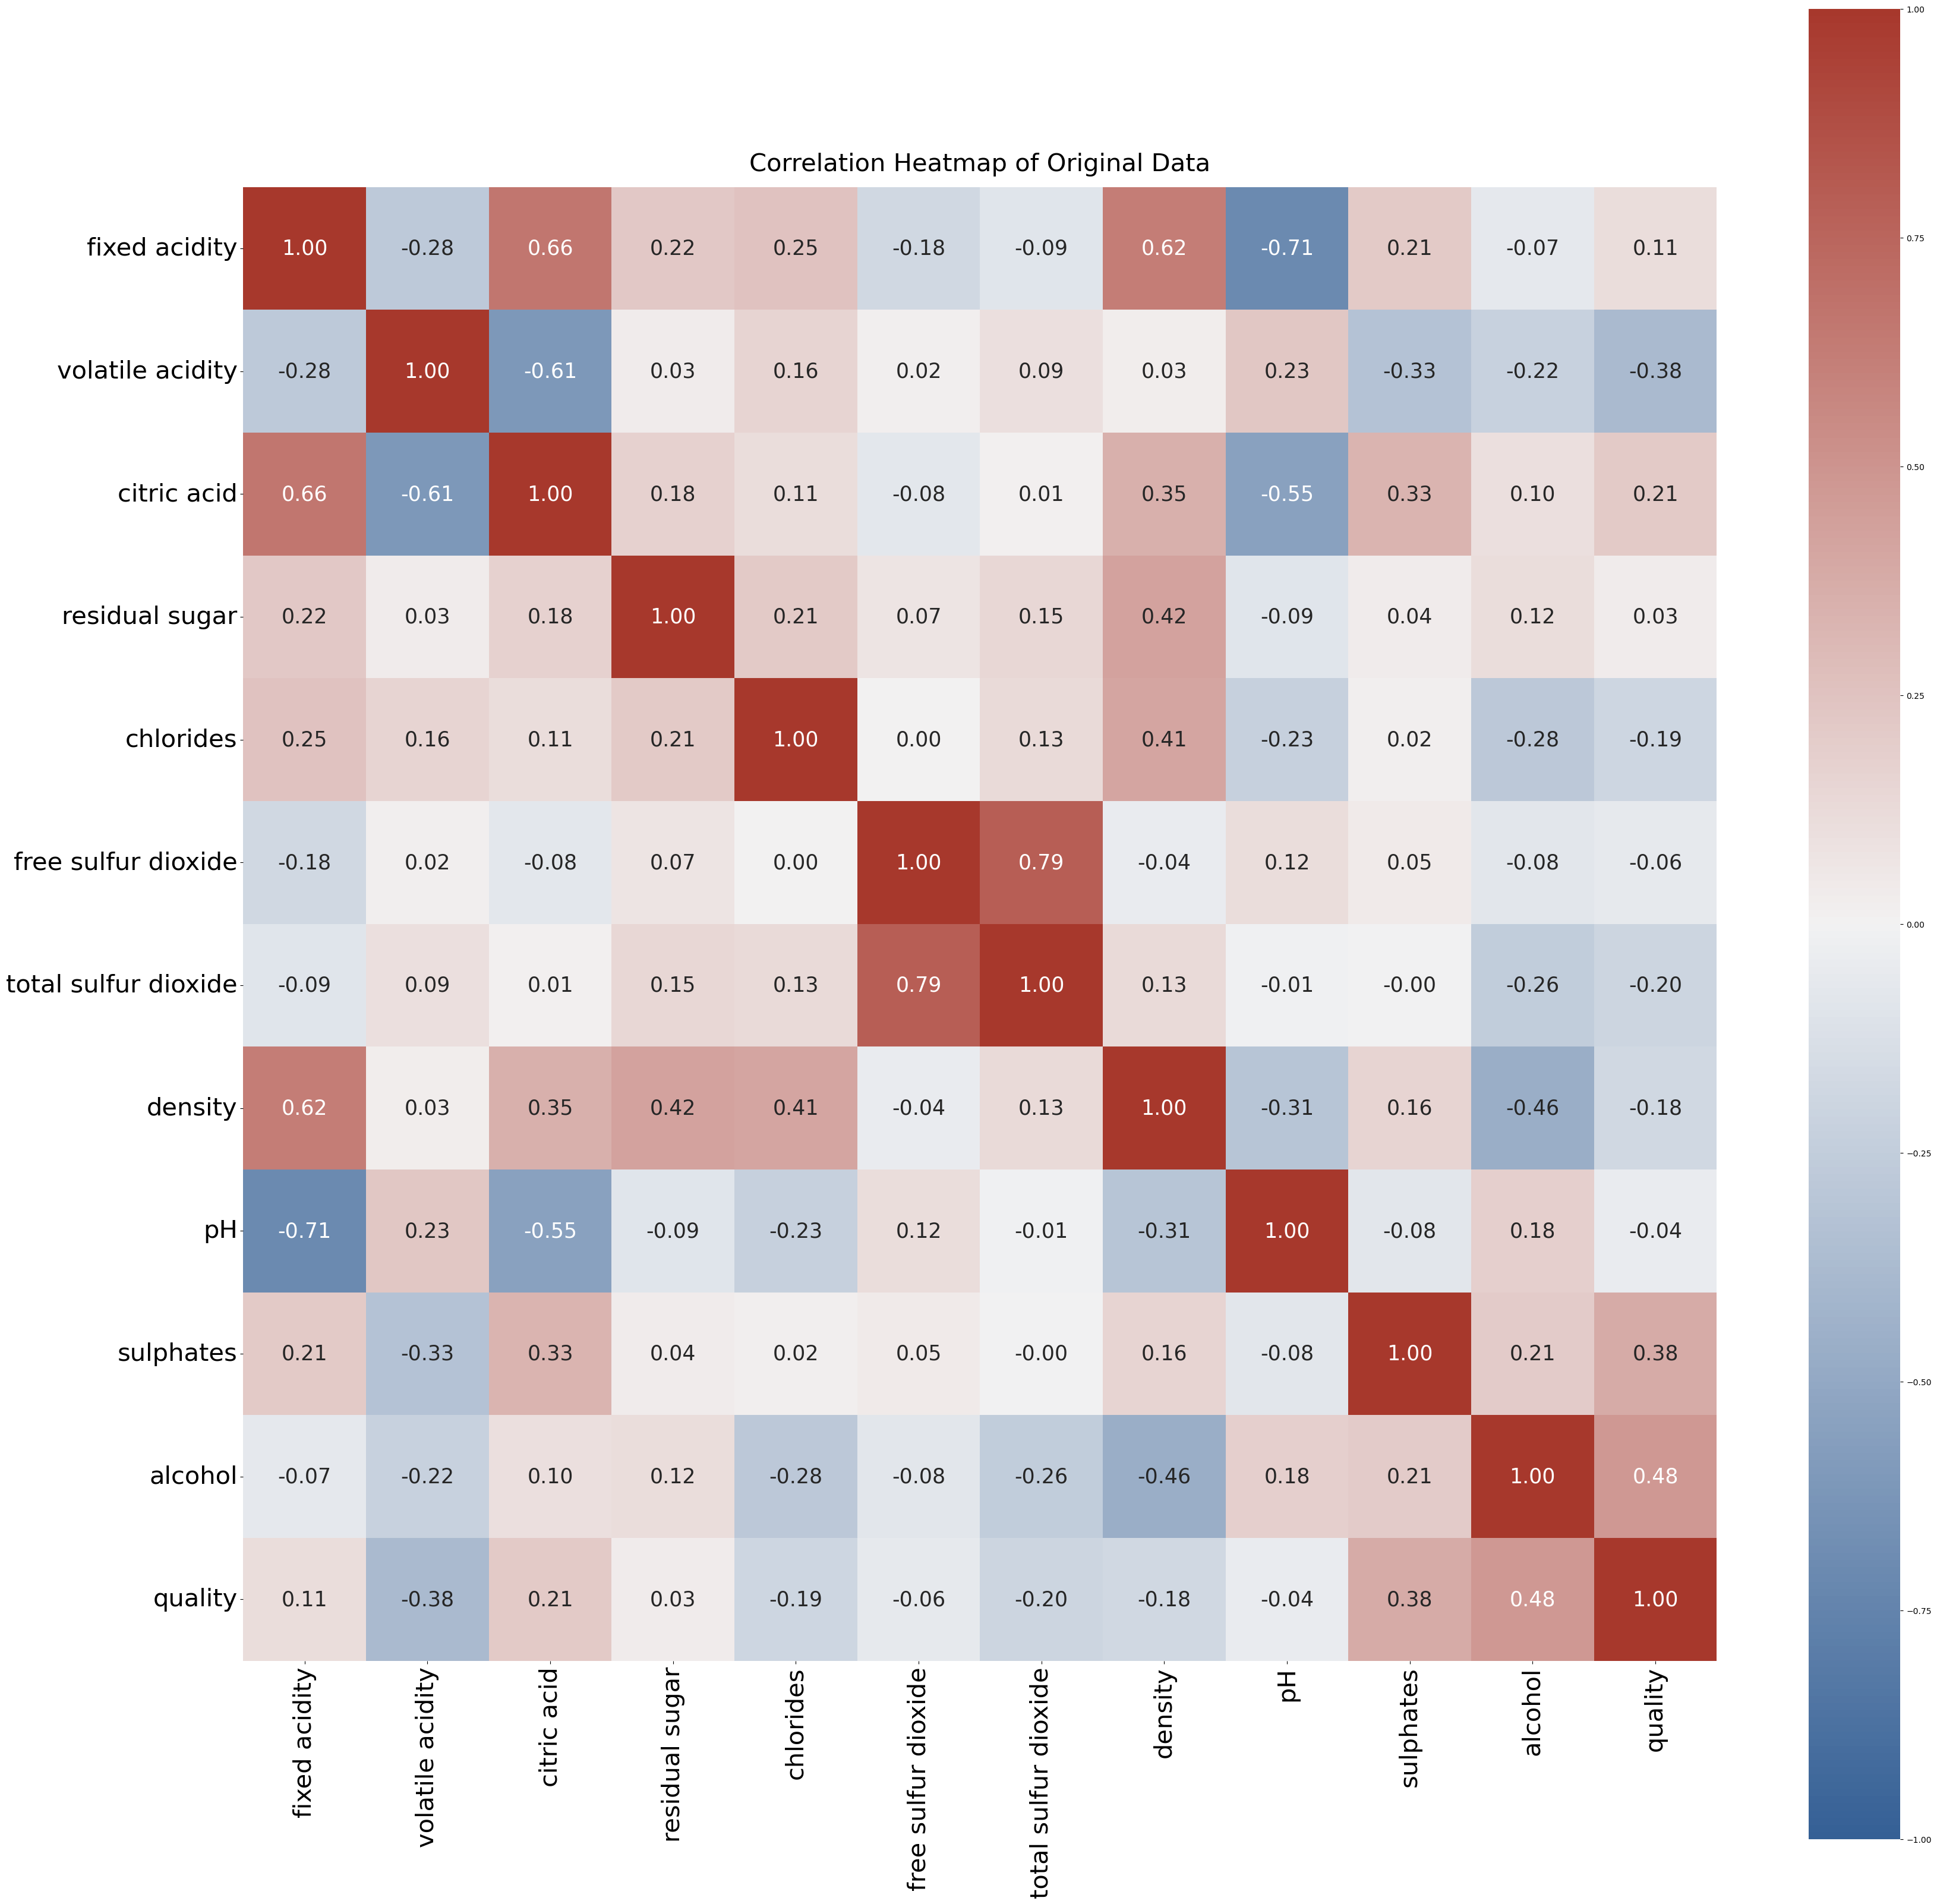

In [65]:
cov_matrix= original_data.corr(method='spearman')

cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)

plt.figure(figsize=(40,40))
sns.heatmap(cov_matrix,  center=0, annot=True,fmt='.2f', square=True, cmap=cmap,vmin=-1, vmax=1,annot_kws={"size": 25})
plt.xticks(fontsize=30,rotation=90)
plt.yticks(fontsize=30,rotation=0)
plt.title('Correlation Heatmap of Original Data', fontsize=30, pad=20) 
plt.show()

In [67]:

original_data_float=original_data.astype(float)
chi_square_value, p_value = calculate_bartlett_sphericity(original_data_float)
print(chi_square_value, p_value)
kmo_all, kmo_model = calculate_kmo(original_data_float)
print("KMO:", kmo_model)

8728.272931062467 0.0
KMO: 0.46584000576541595


D:\anaconda\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
